# <font color='purple'>Opera 18 days REIMAGED - Preprocessing QC statistics </font> 
## October 2024


In [2]:
import os
NOVA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps'
NOVA_DATA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps'
LOGS_PATH = os.path.join(NOVA_DATA_HOME, "outputs/preprocessing/Opera18Days_Reimaged/logs/")
PLOT_PATH = os.path.join(NOVA_DATA_HOME, "outputs/preprocessing/Opera18Days_Reimaged/logs/plots")
os.chdir(NOVA_HOME)
import pandas as pd
import contextlib
import io
from IPython.display import display, Javascript

from tools.preprocessing_tools.qc_reports.qc_utils import log_files_qc, run_validate_folder_structure, display_diff, sample_and_calc_variance, \
                                                show_site_survival_dapi_brenner, show_site_survival_dapi_cellpose, \
                                                show_site_survival_dapi_tiling, show_site_survival_target_brenner, \
                                                calc_total_sums, plot_filtering_heatmap, show_total_sum_tables, \
                                                plot_cell_count, plot_catplot, plot_hm_combine_batches, plot_hm, \
                                                run_calc_hist_new
                                                
from tools.preprocessing_tools.qc_reports.qc_config import opera18days_panels, opera18days_markers, opera18days_marker_info, \
                                                opera18days_cell_lines, opera18days_cell_lines_to_cond,\
                                                opera18days_cell_lines_for_disp, opera18days_reps, \
                                                opera18days_line_colors, opera18days_lines_order, \
                                                opera18days_custom_palette, opera18days_expected_dapi_raw, \
                                                markers
%load_ext autoreload
%autoreload 2

In [3]:
df = log_files_qc(LOGS_PATH,only_wt_cond=False, filename_split='-',site_location=0)
df_dapi = df[df.marker=='DAPI']
df_target = df[df.marker!='DAPI']

reading logs of batch2
reading logs of batch1

Total of 2 files were read.
Before dup handeling  (120169, 22)
After duplication removal #1: (120169, 23)
After duplication removal #2: (120169, 23)


In [5]:
# choose batches
batches = ['batch1', 'batch2']
batches

['batch1', 'batch2']

## Actual Files Validation

### Raw Files Validation

1. How many site **tiff** files do we have in each folder?
2. Are all existing files valid? (tif or tiff, at least 1MB, not corrupetd)

batch1
Folder structure is valid.
No bad files are found.
Total Sites:  82000


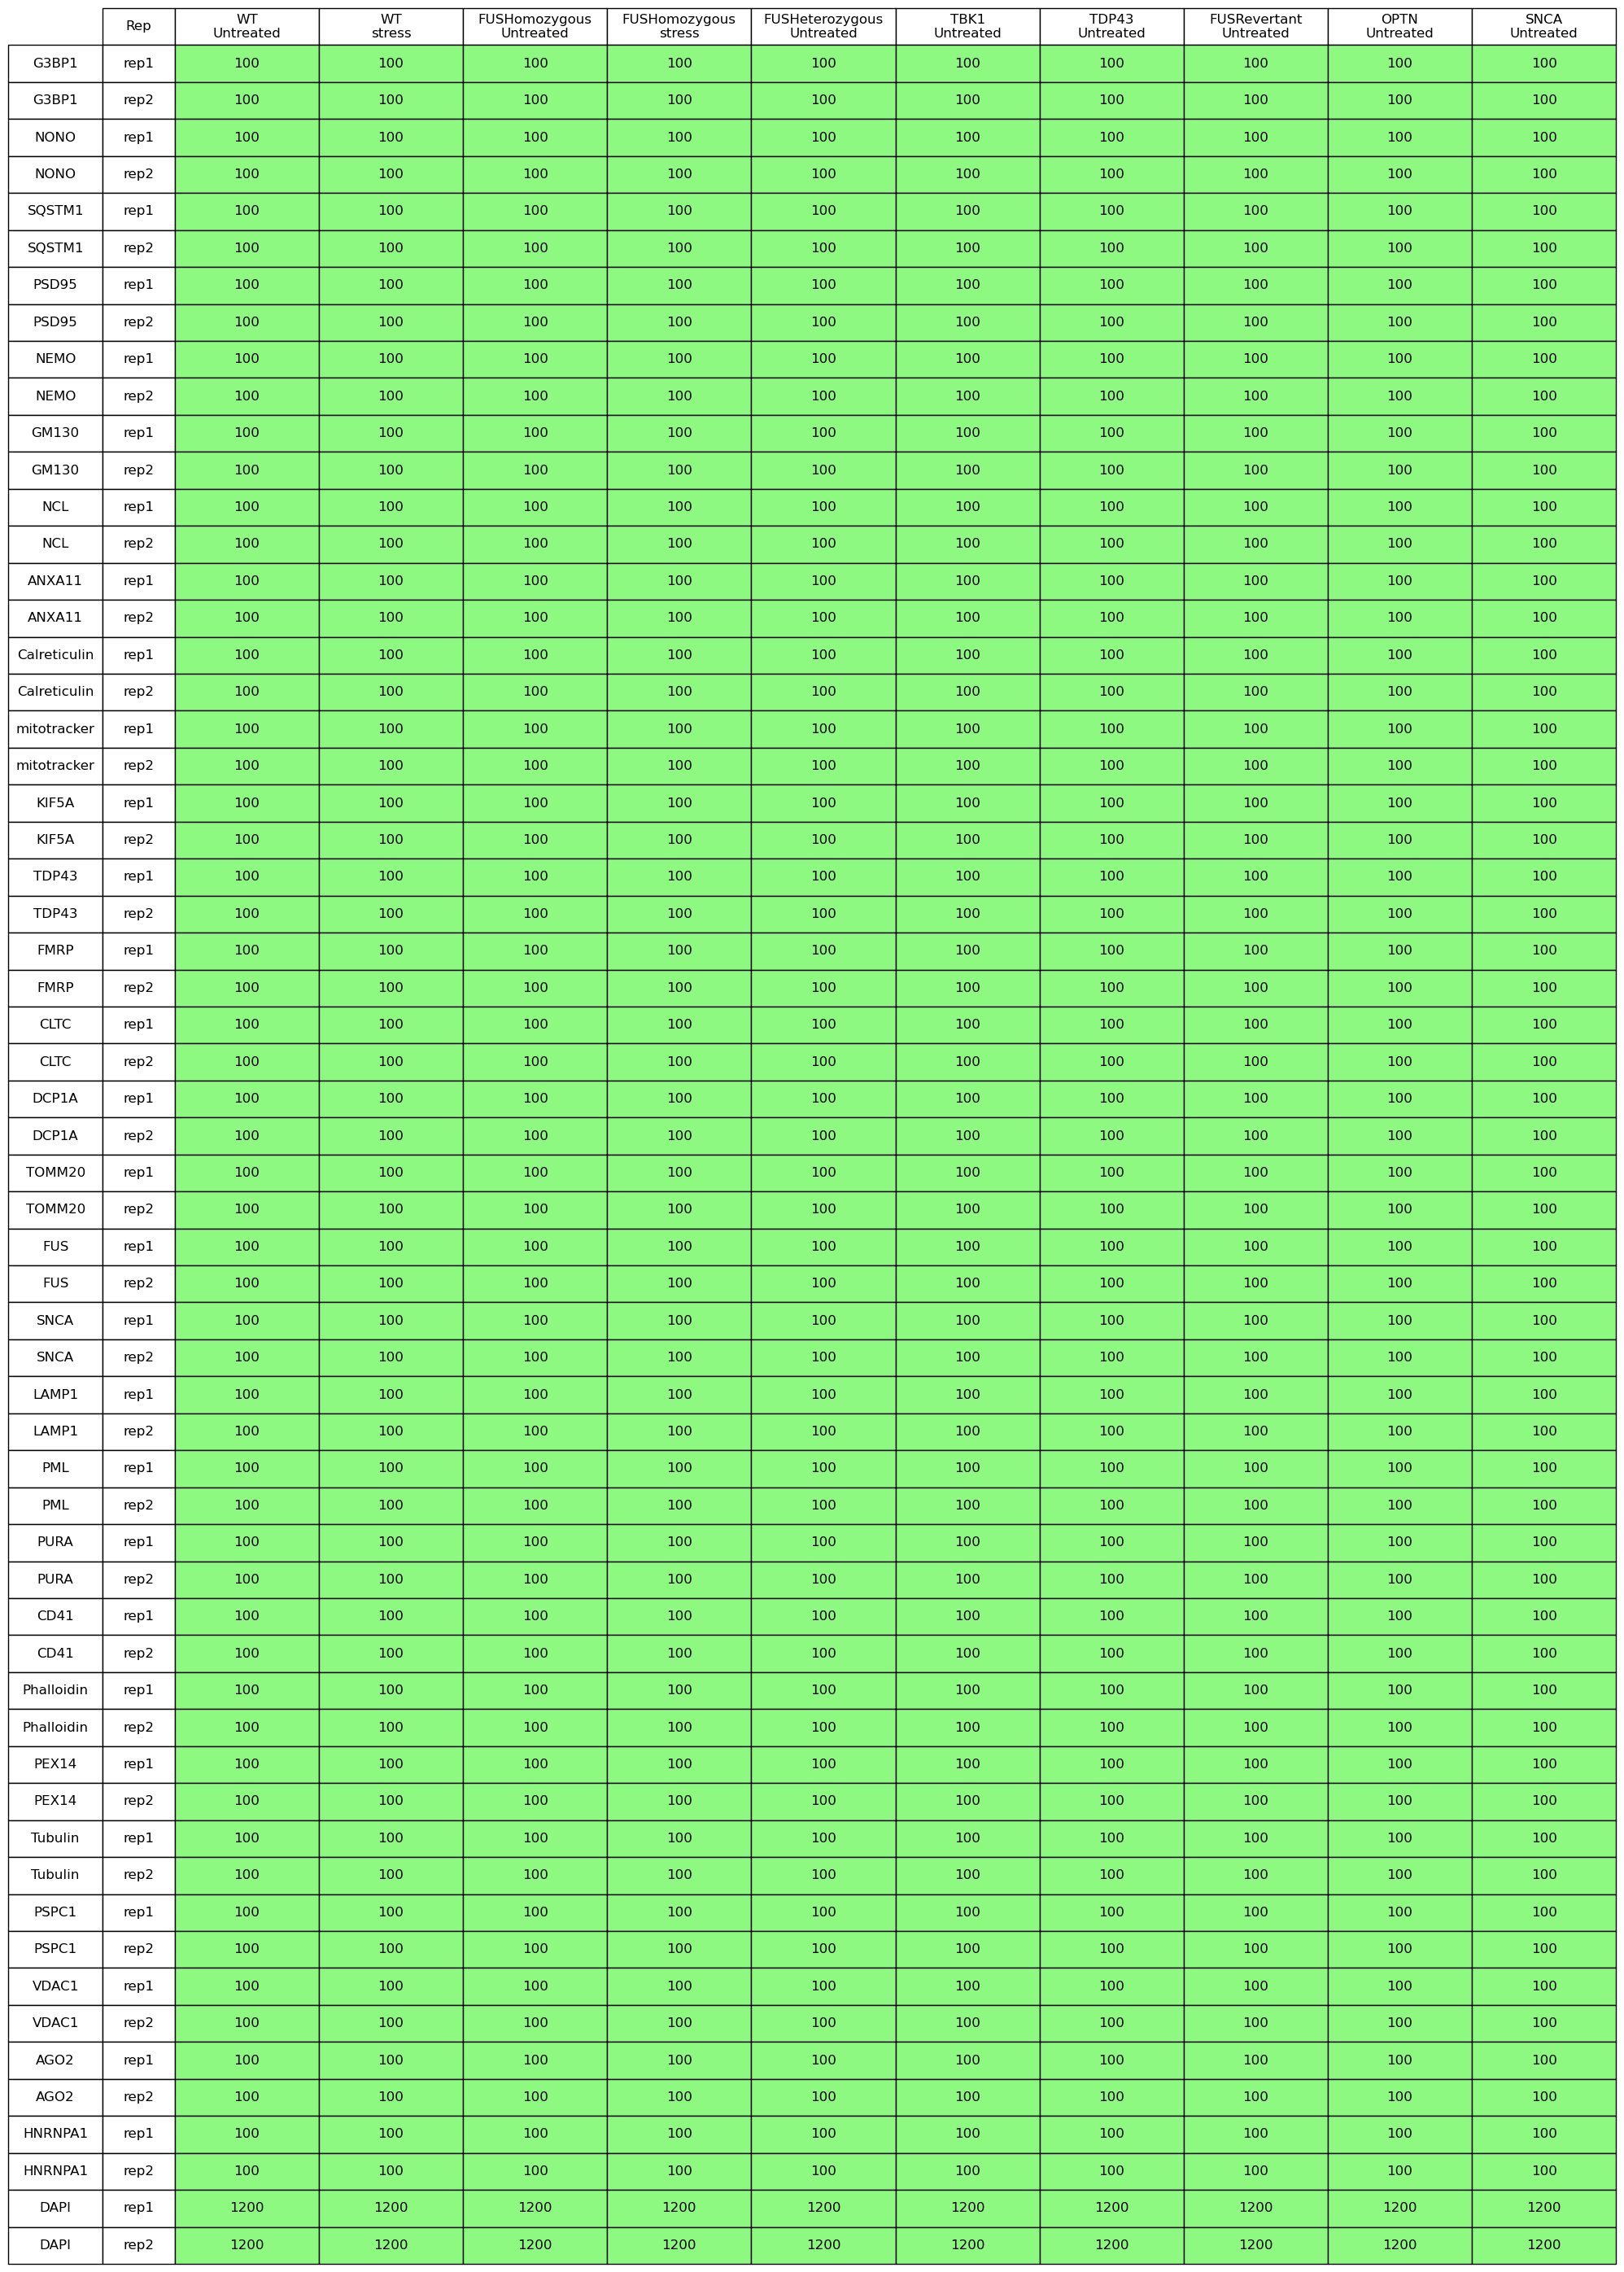

batch2
Folder structure is valid.
No bad files are found.
Total Sites:  82000


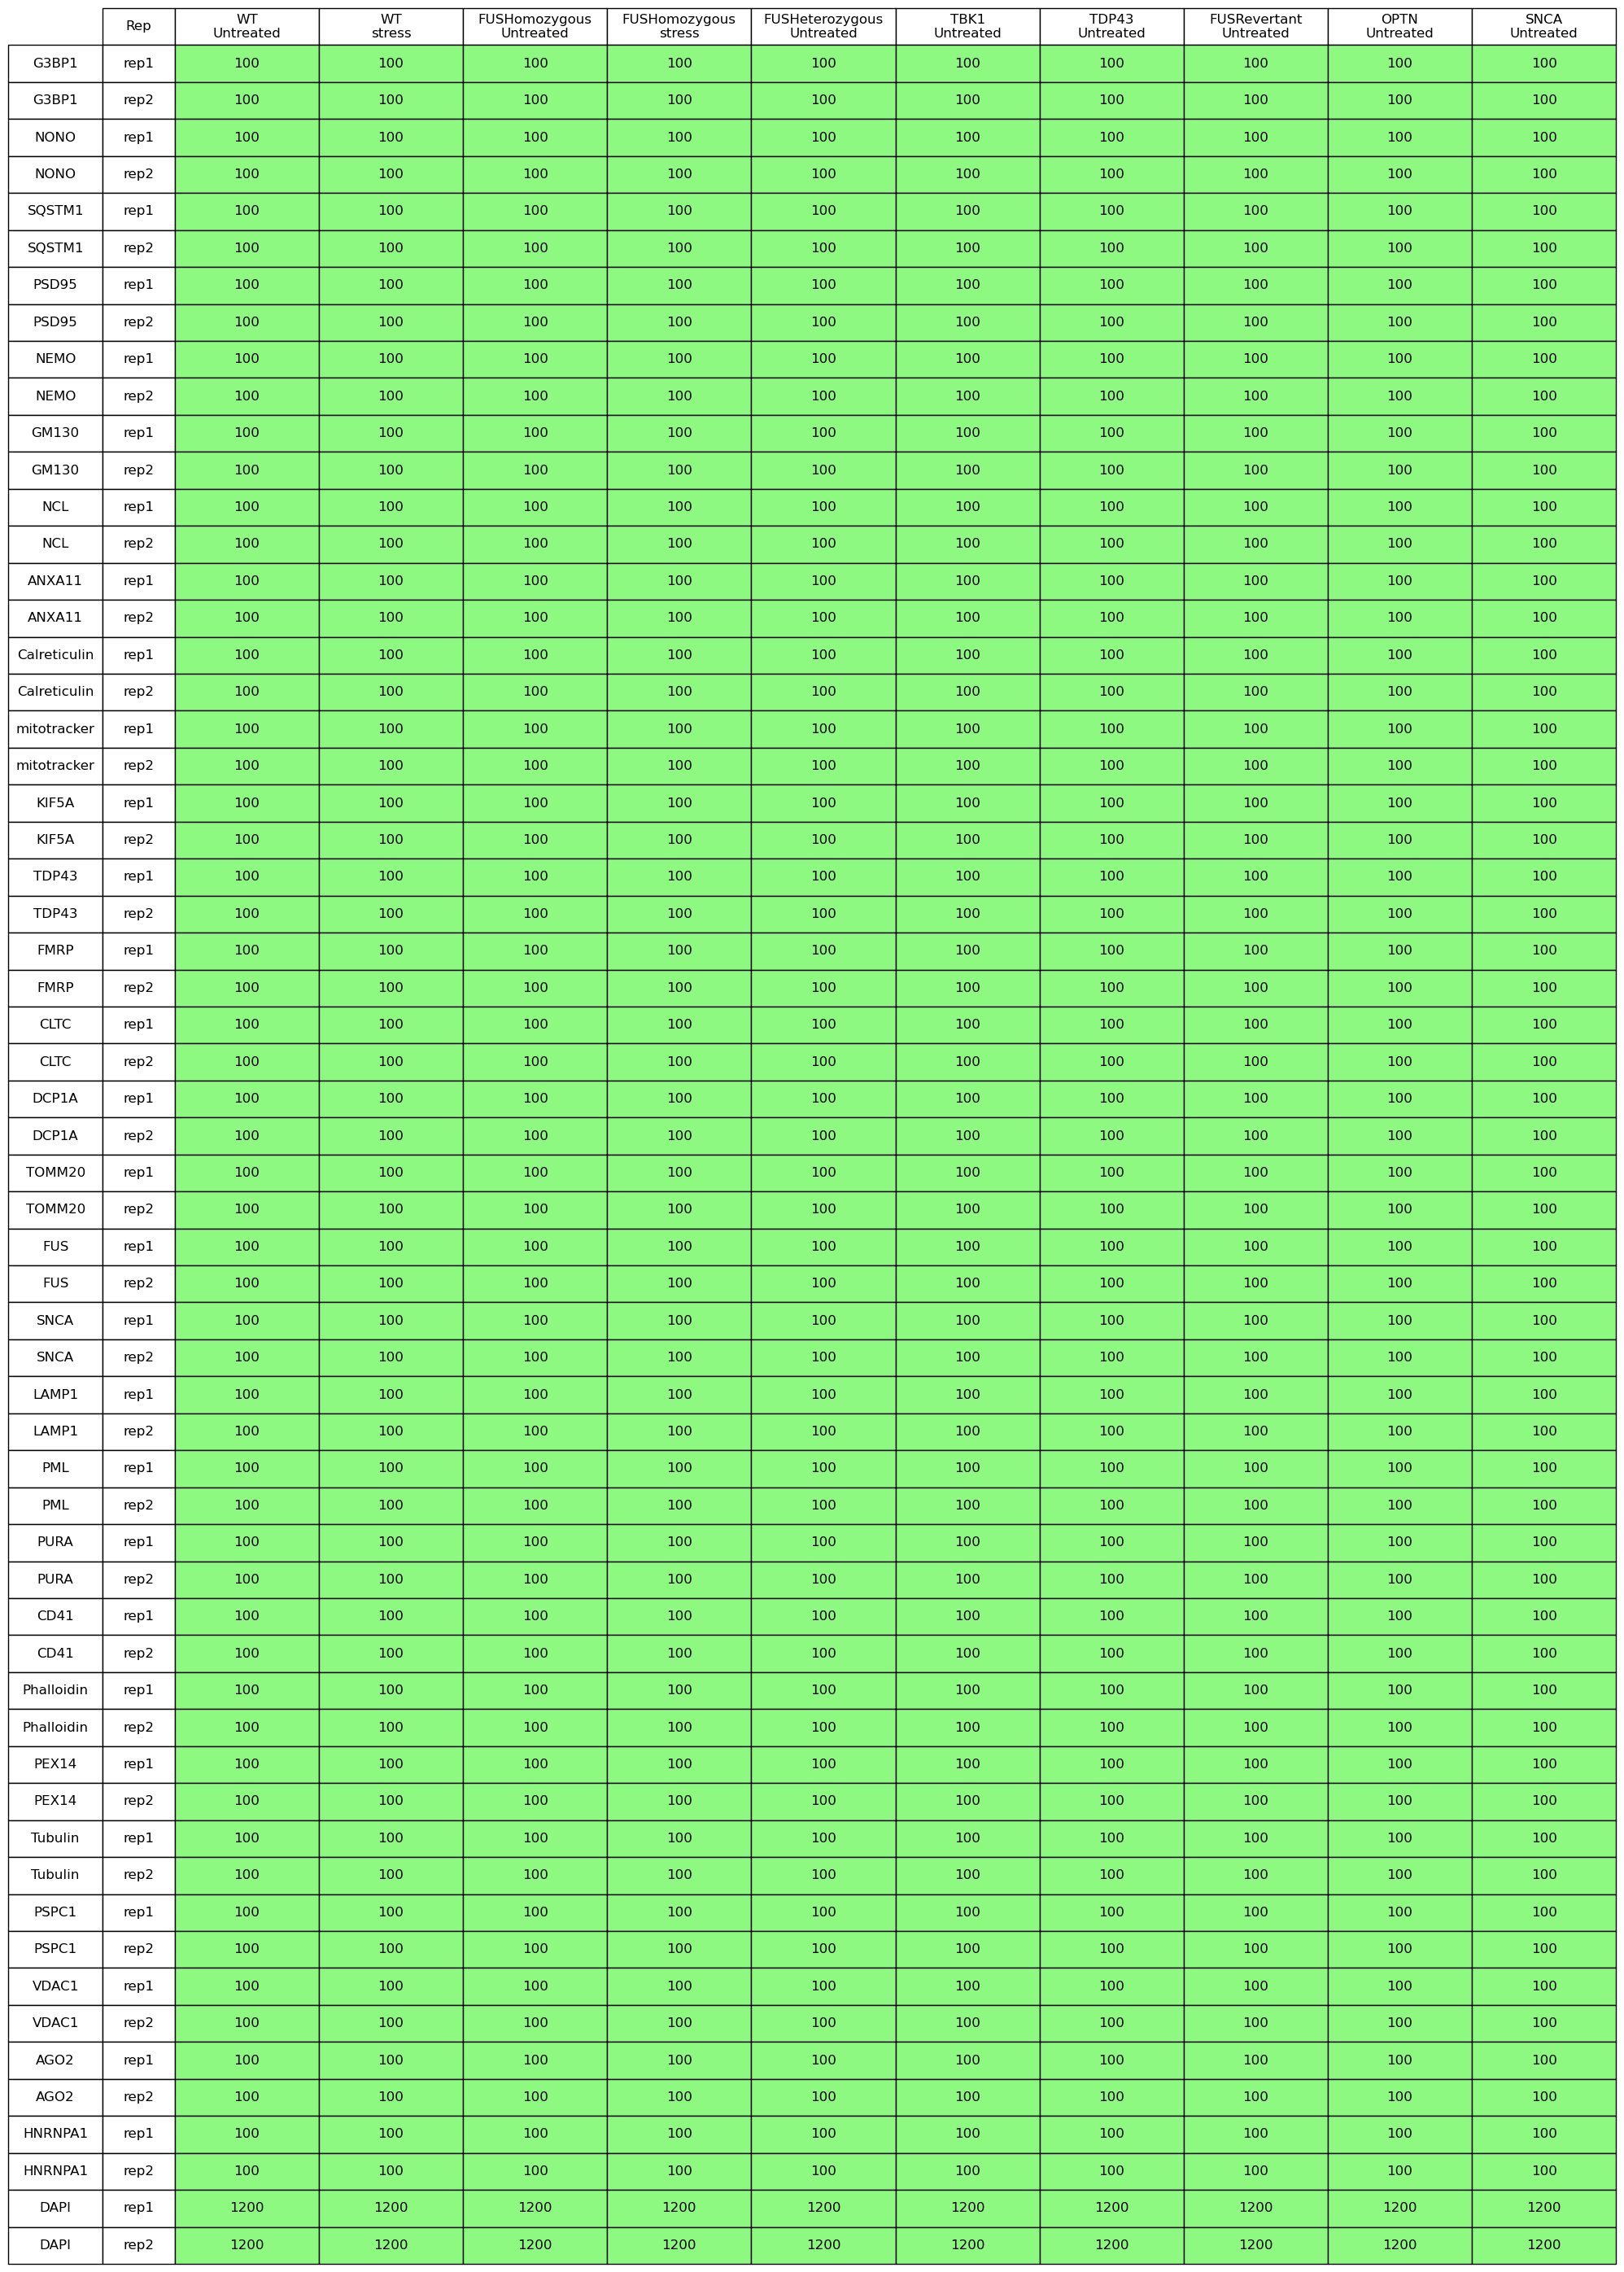

In [7]:

root_directory_raw = os.path.join(NOVA_DATA_HOME, 'input', 'images', 'raw', 'Opera18DaysReimaged_sorted')

batches_raw = [batch.replace("_16bit_no_downsample","") for batch in batches]
raws = run_validate_folder_structure(root_directory_raw, False, opera18days_panels, opera18days_markers.copy(),PLOT_PATH, opera18days_marker_info,
                                    opera18days_cell_lines_to_cond, opera18days_reps, opera18days_cell_lines_for_disp, opera18days_expected_dapi_raw,
                                     batches=batches_raw, fig_height=12)

### Processed Files Validation

1. How many site **npy** files do we have in each folder? -> How many sites survived the pre-processing?
2. Are all existing files valid? (at least 100kB, npy not corrupted)

batch1
Folder structure is valid.
No bad files are found.
Total Sites:  53458


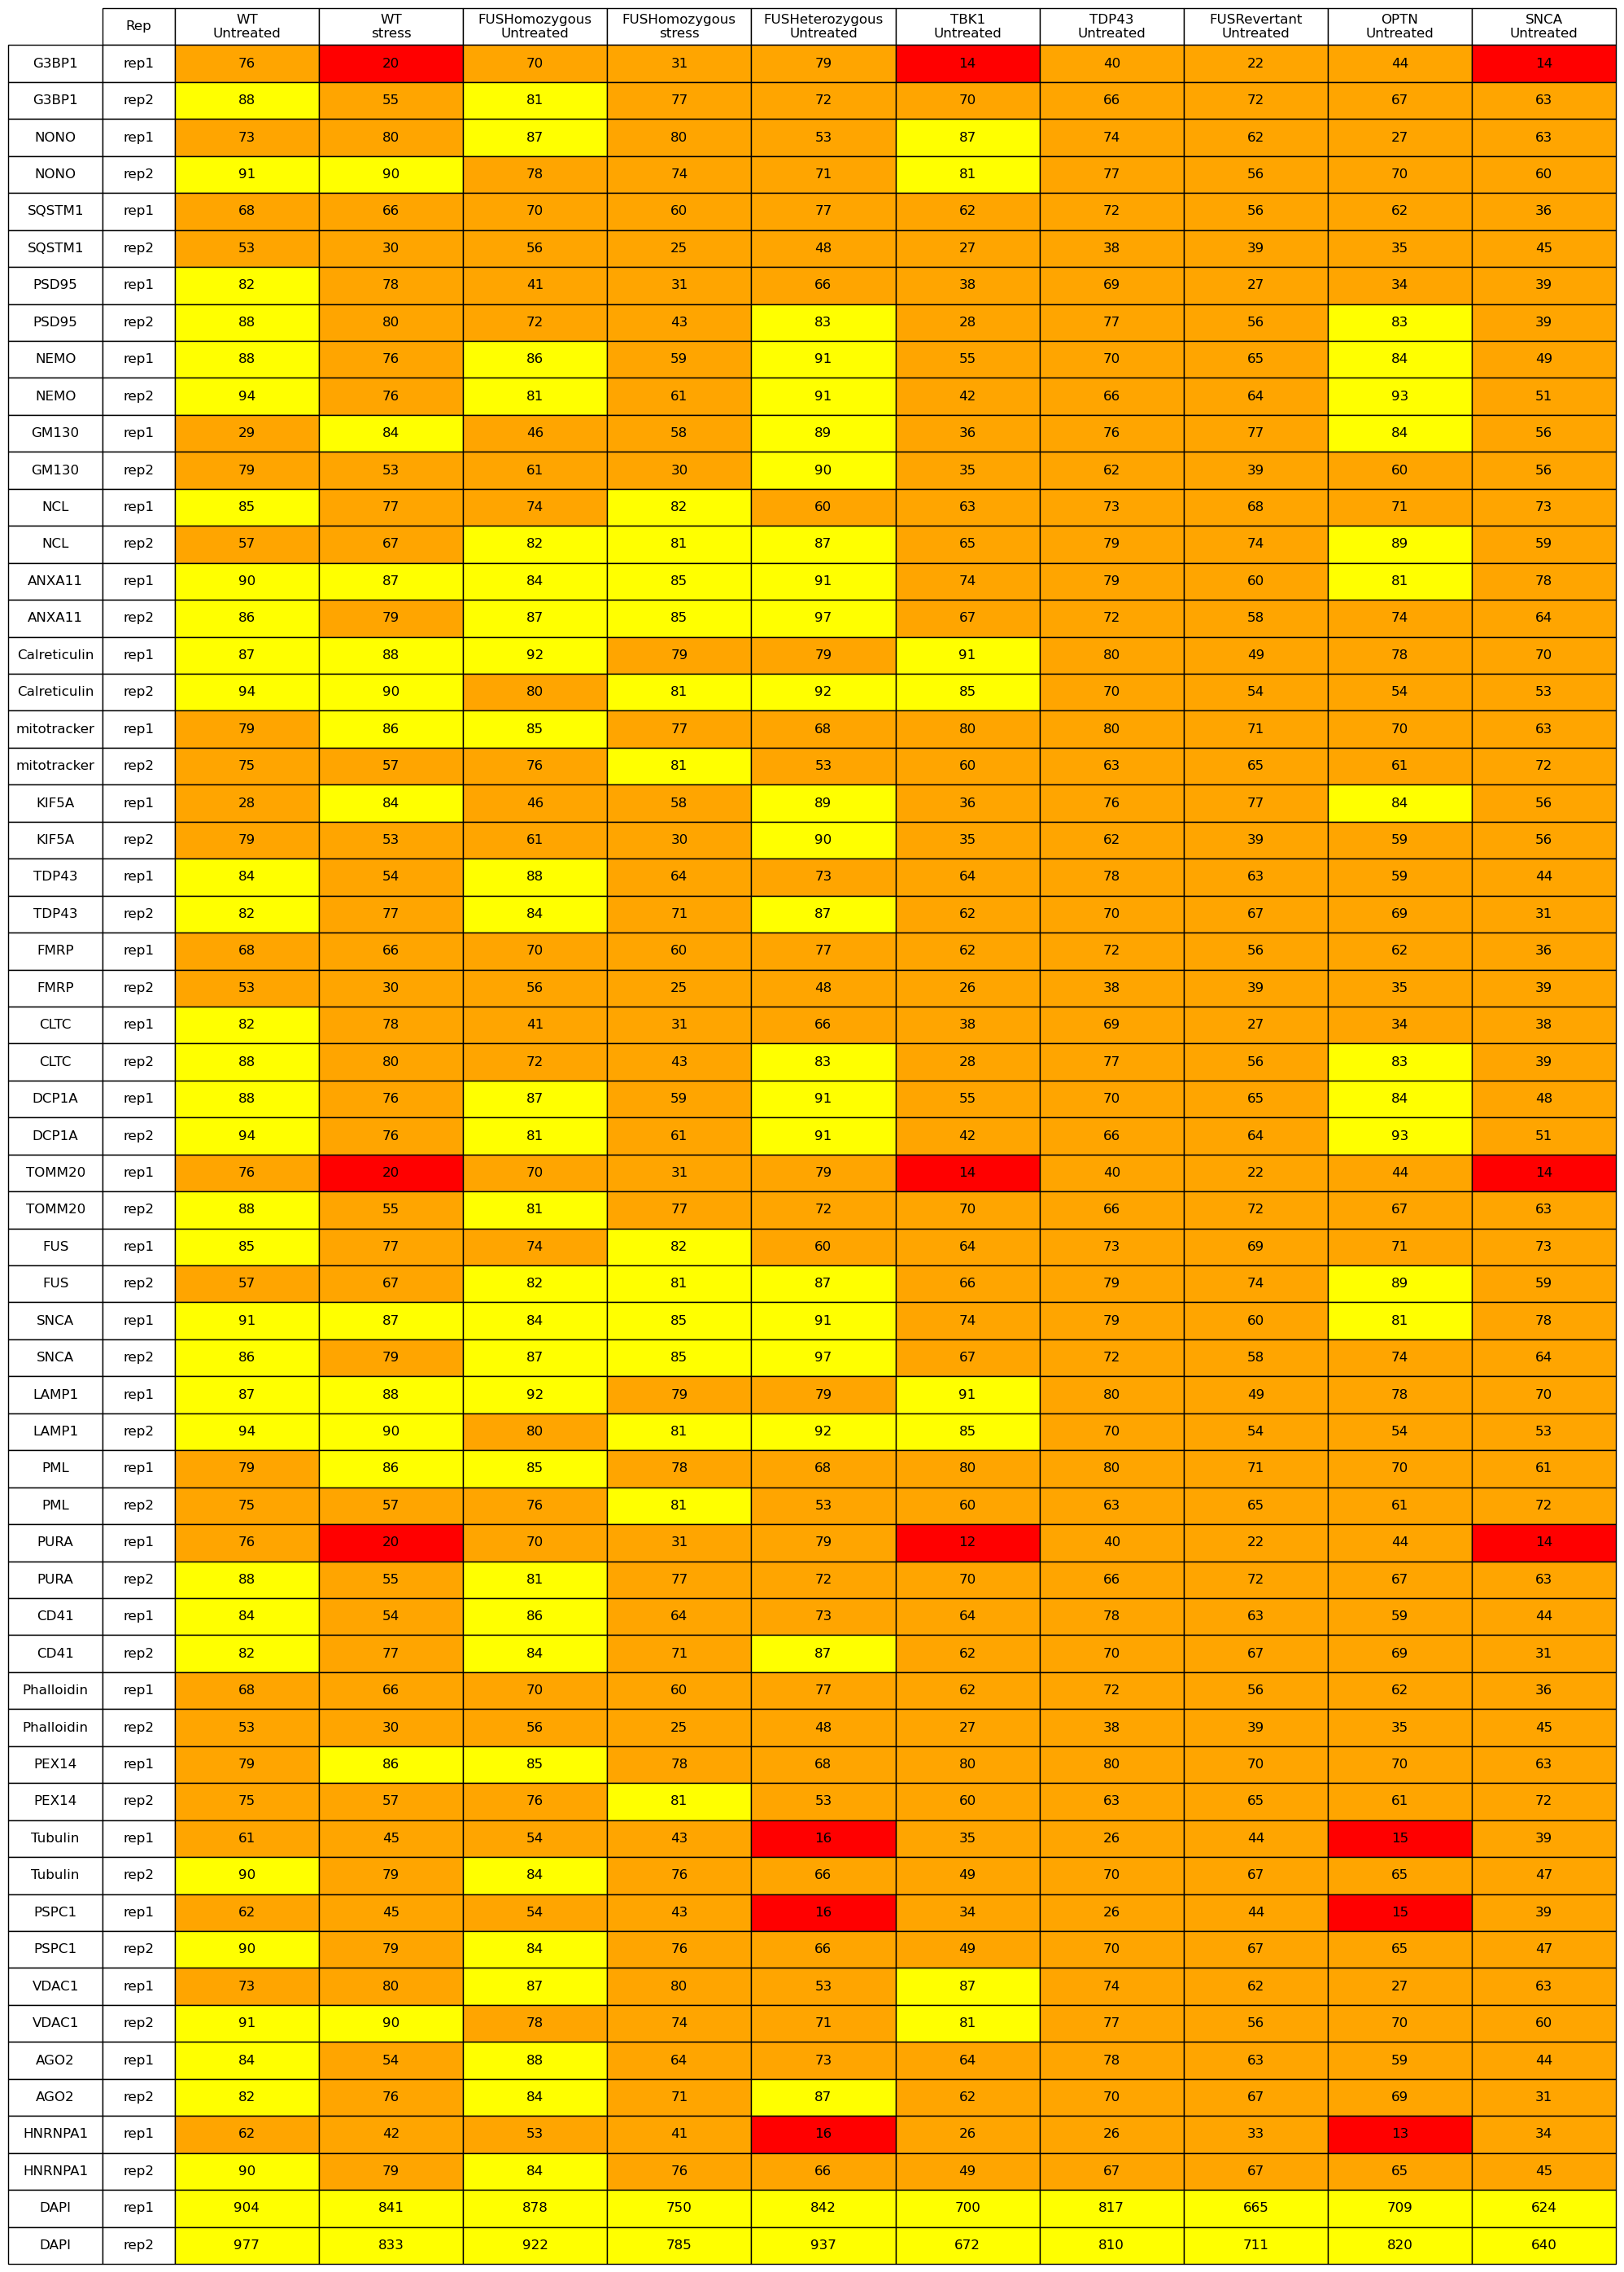

batch2
Folder structure is valid.
No bad files are found.
Total Sites:  51021


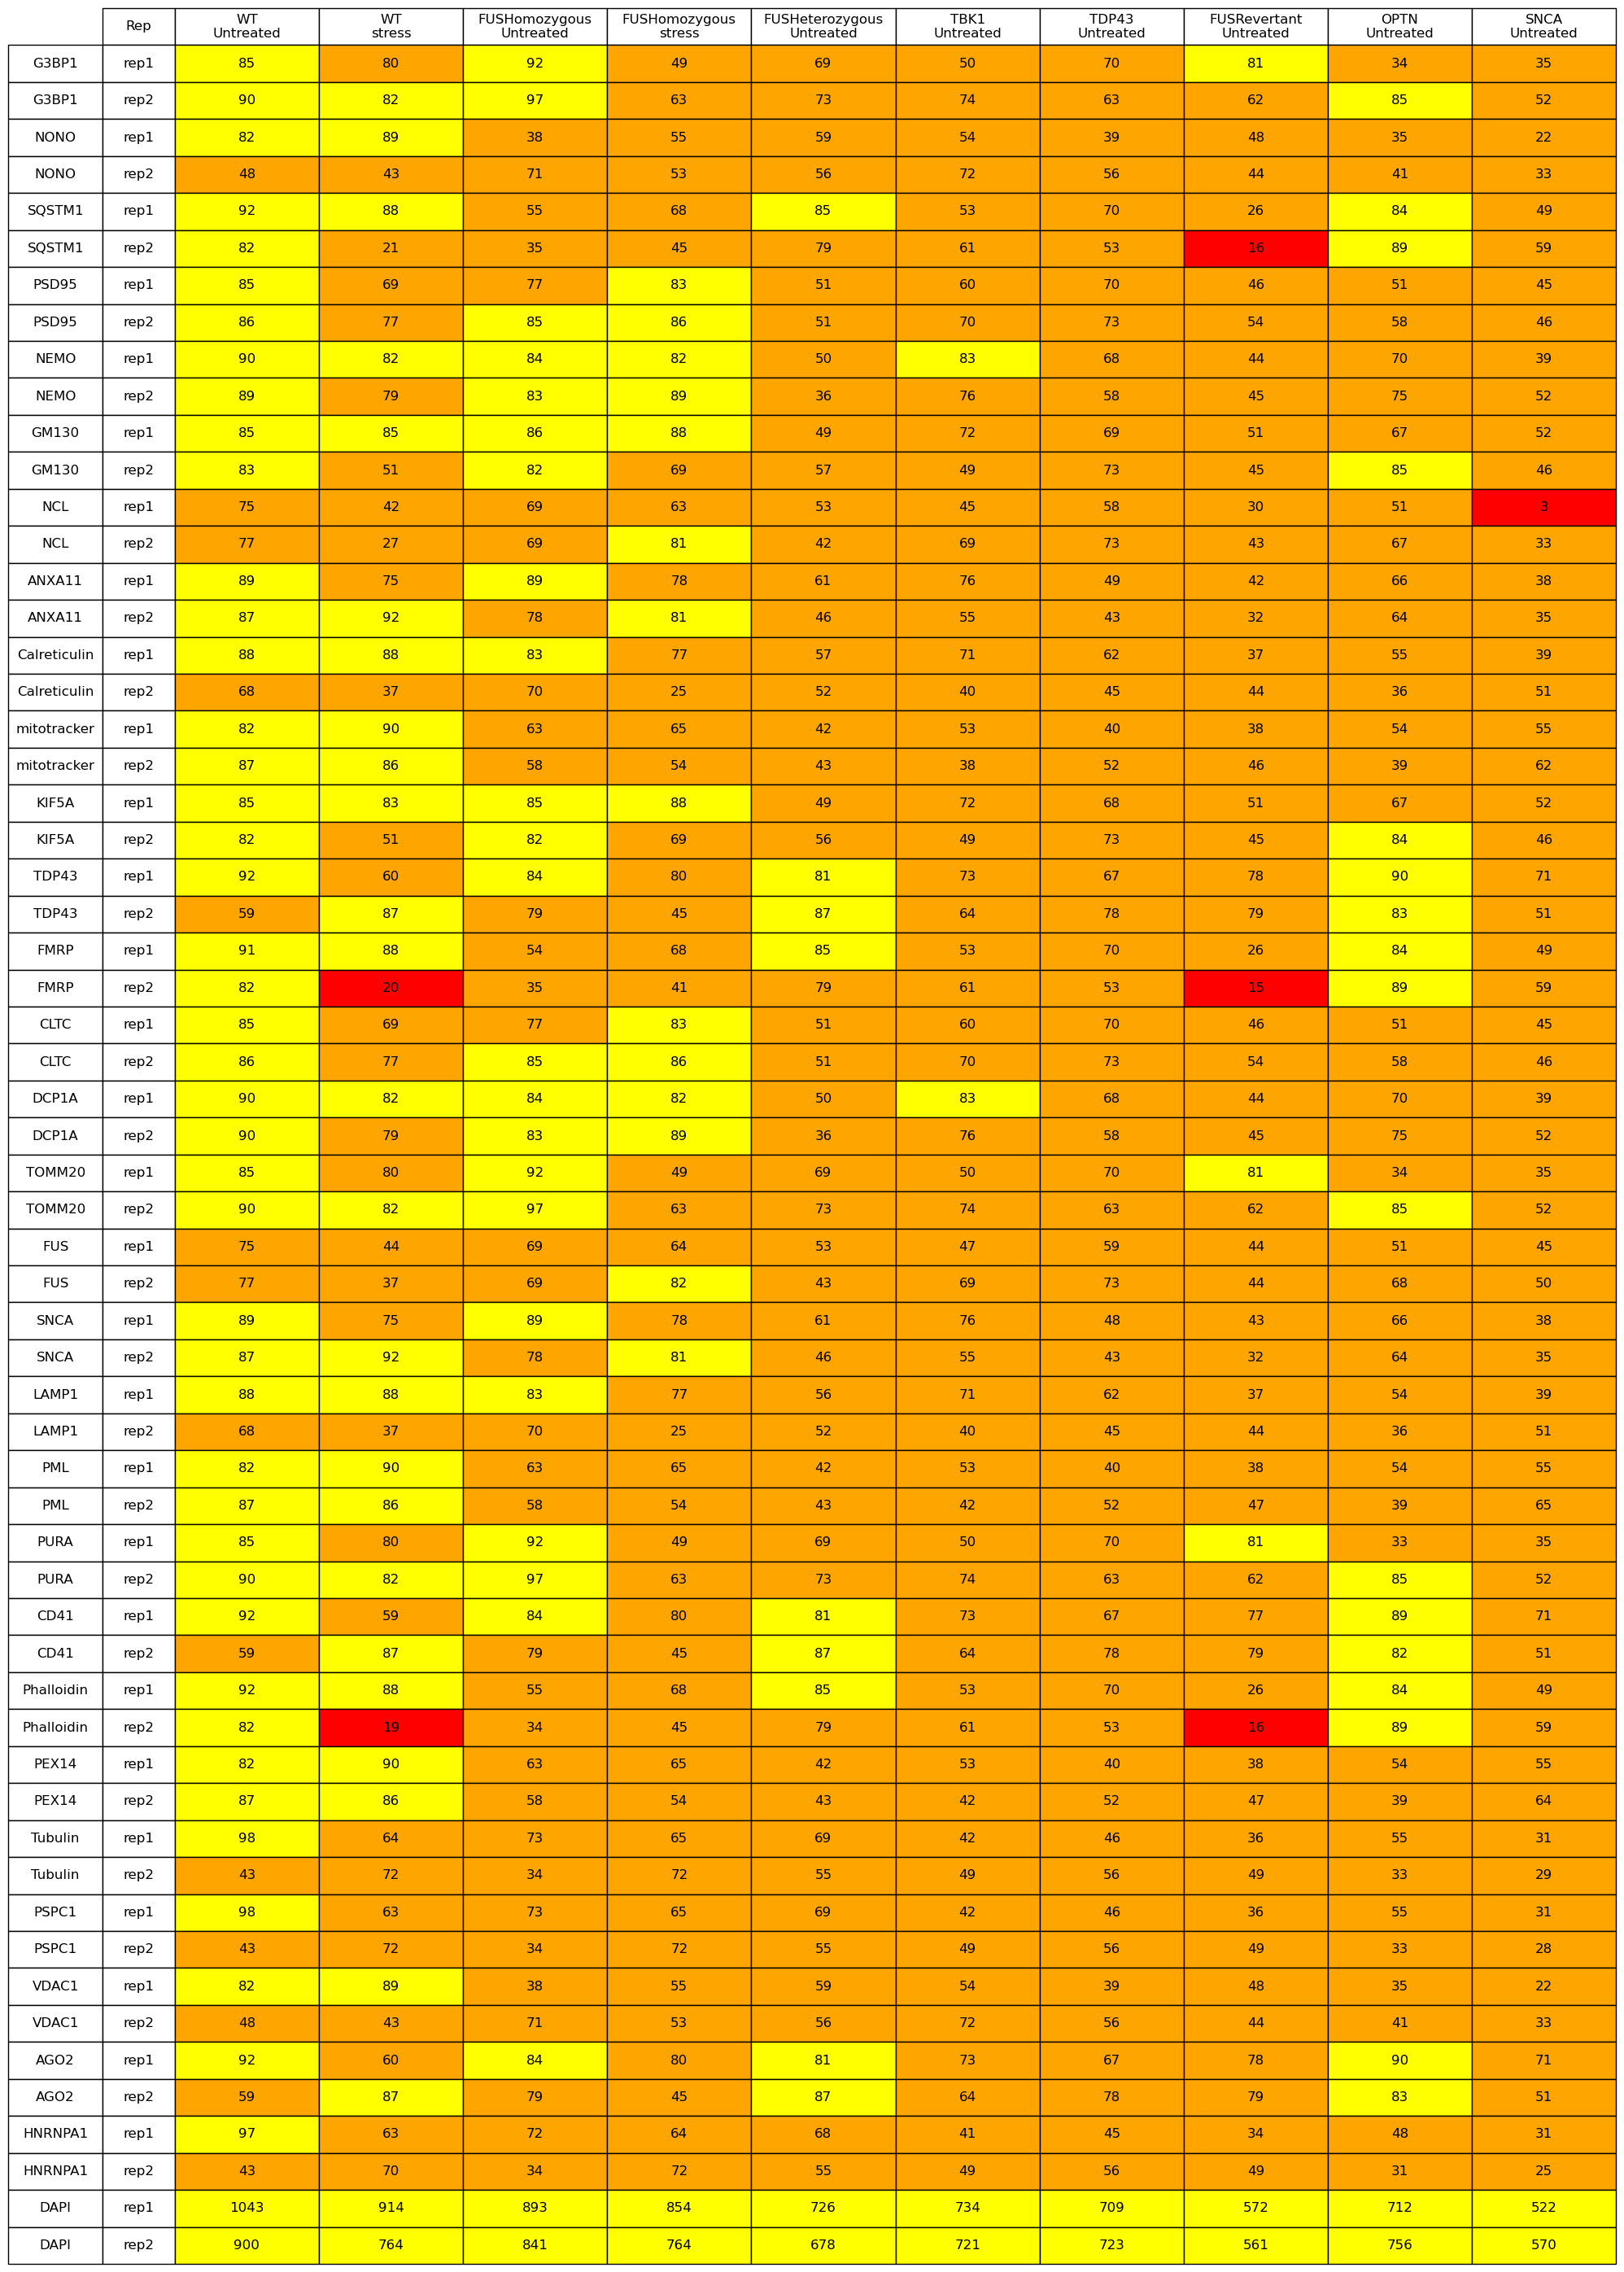

In [8]:
root_directory_proc = os.path.join(NOVA_DATA_HOME, 'input', 'images', 'processed', 'Opera18DaysReimaged')
procs = run_validate_folder_structure(root_directory_proc, True, opera18days_panels, opera18days_markers,PLOT_PATH,opera18days_marker_info,
                                    opera18days_cell_lines_to_cond, opera18days_reps, opera18days_cell_lines_for_disp, opera18days_expected_dapi_raw,
                                     batches=batches, fig_height=12)

### Difference between Raw and Processed

batch1


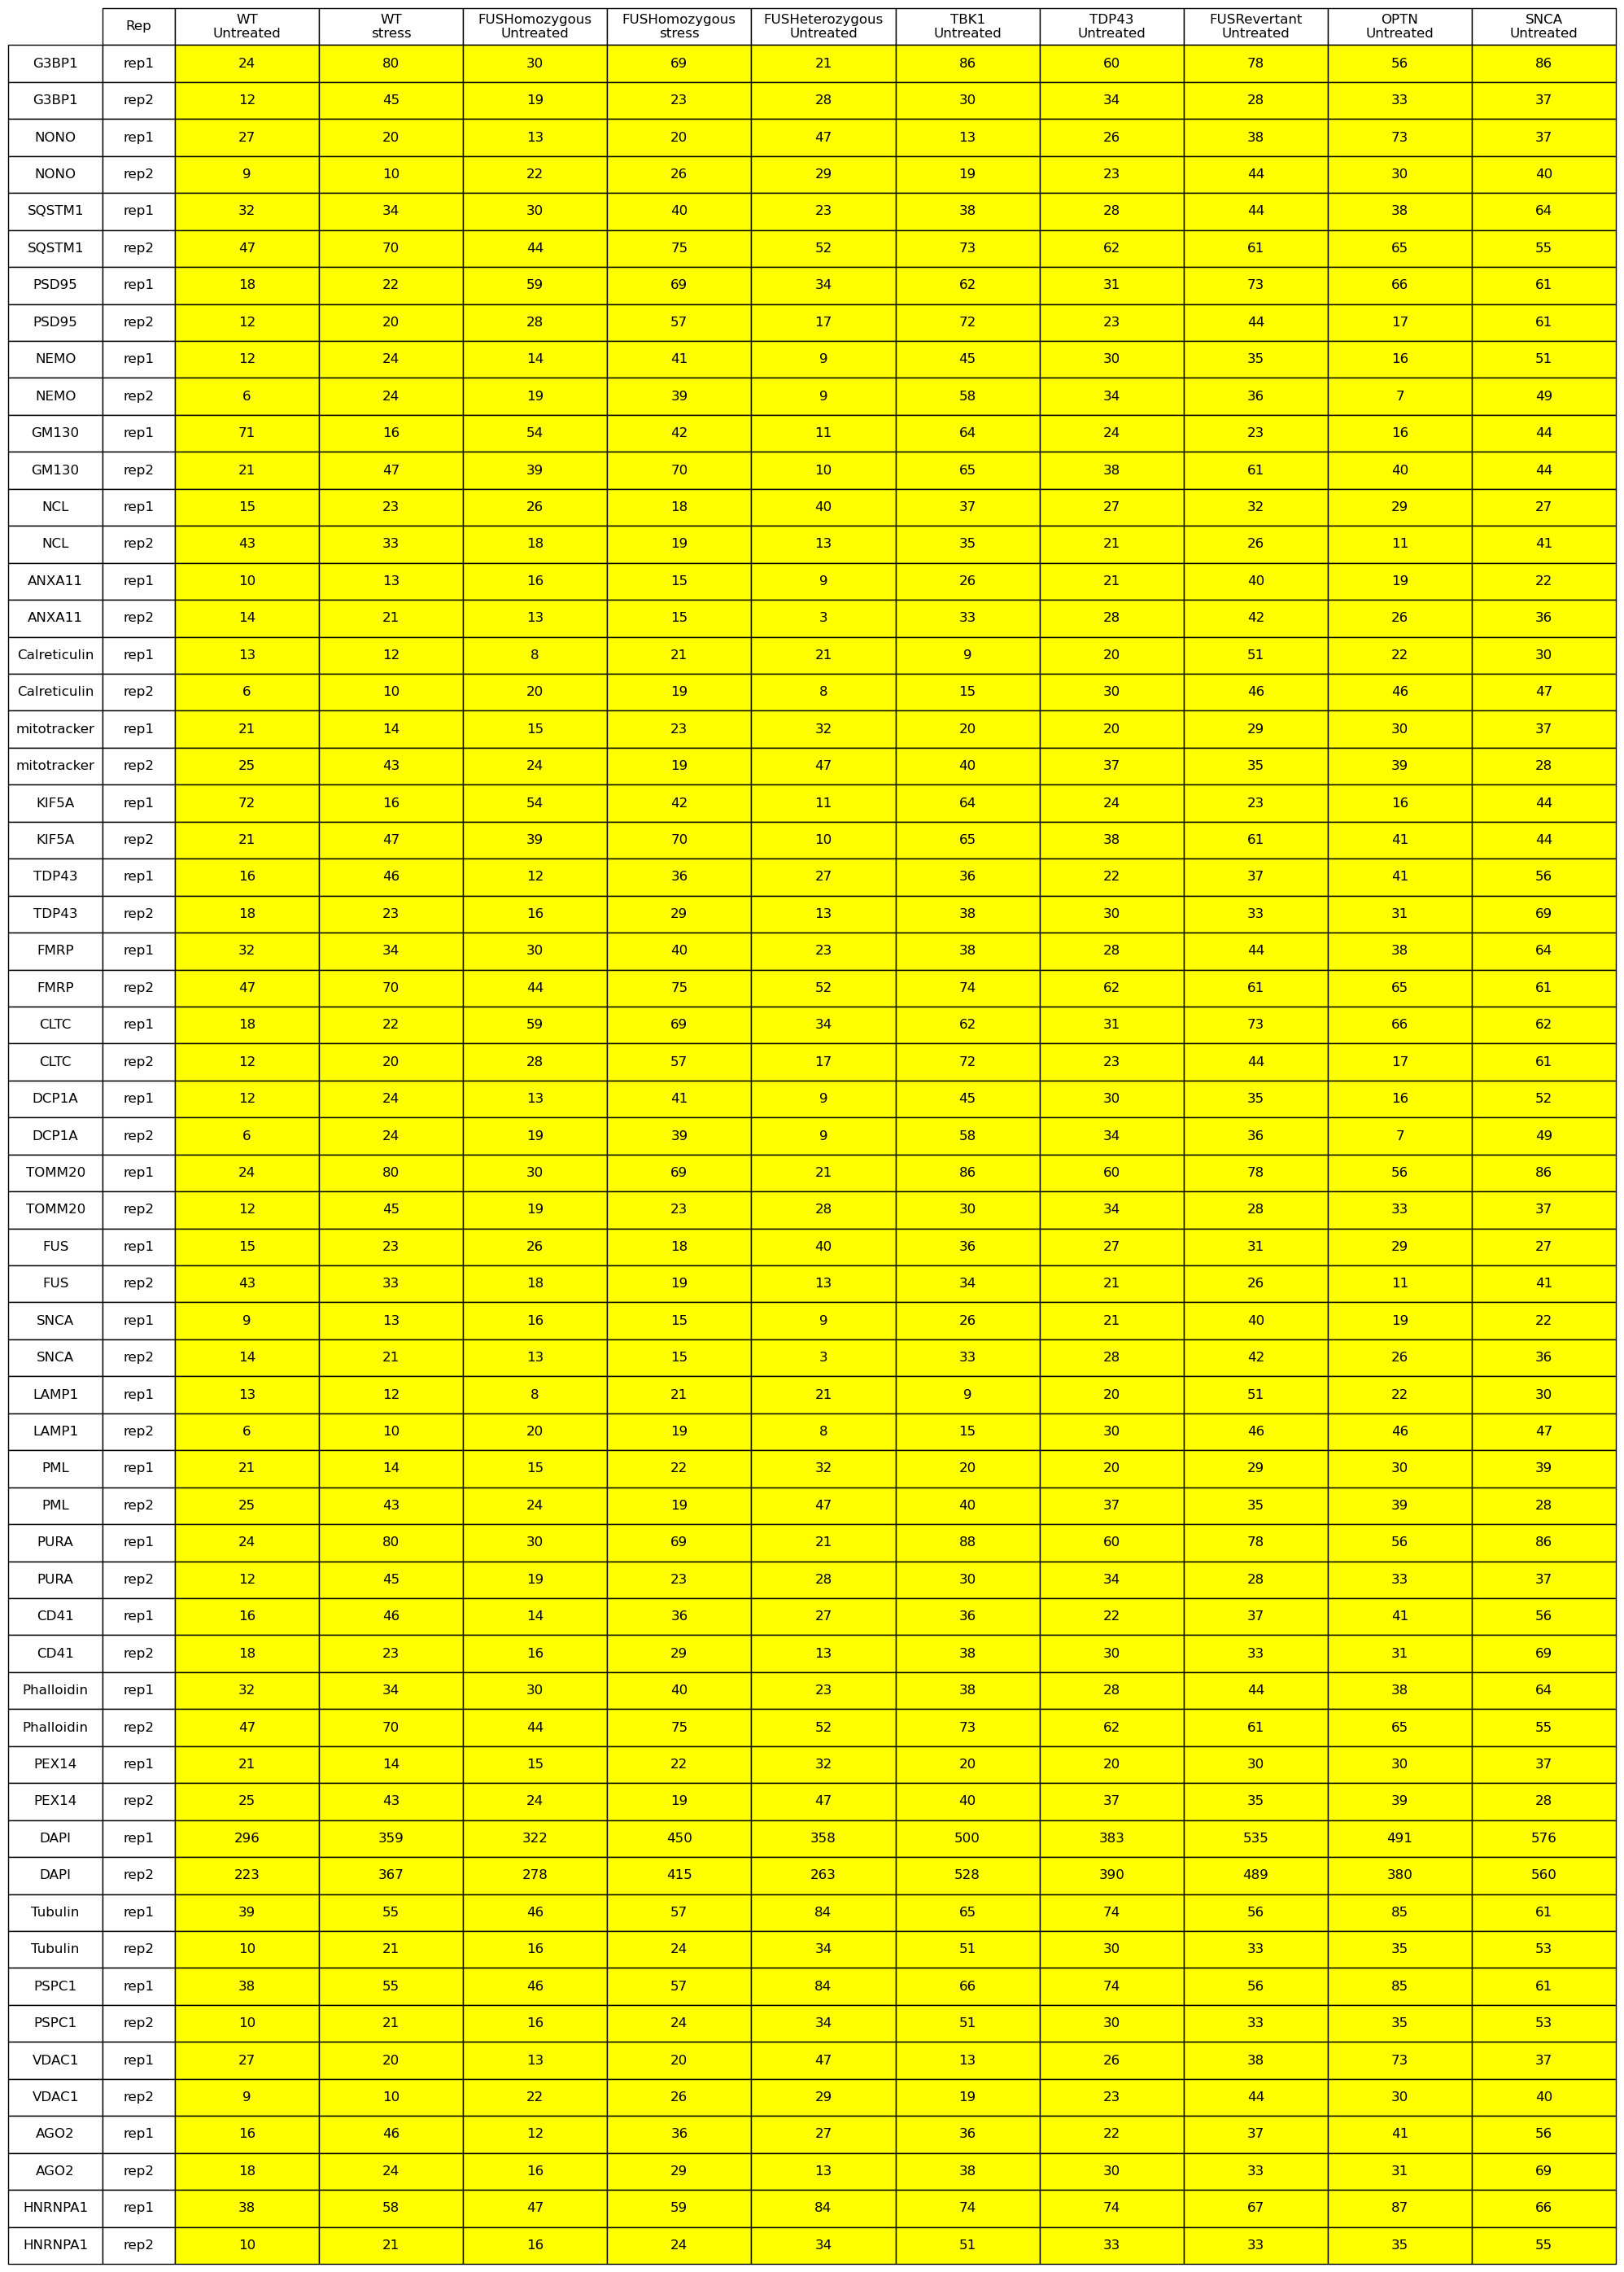

batch2


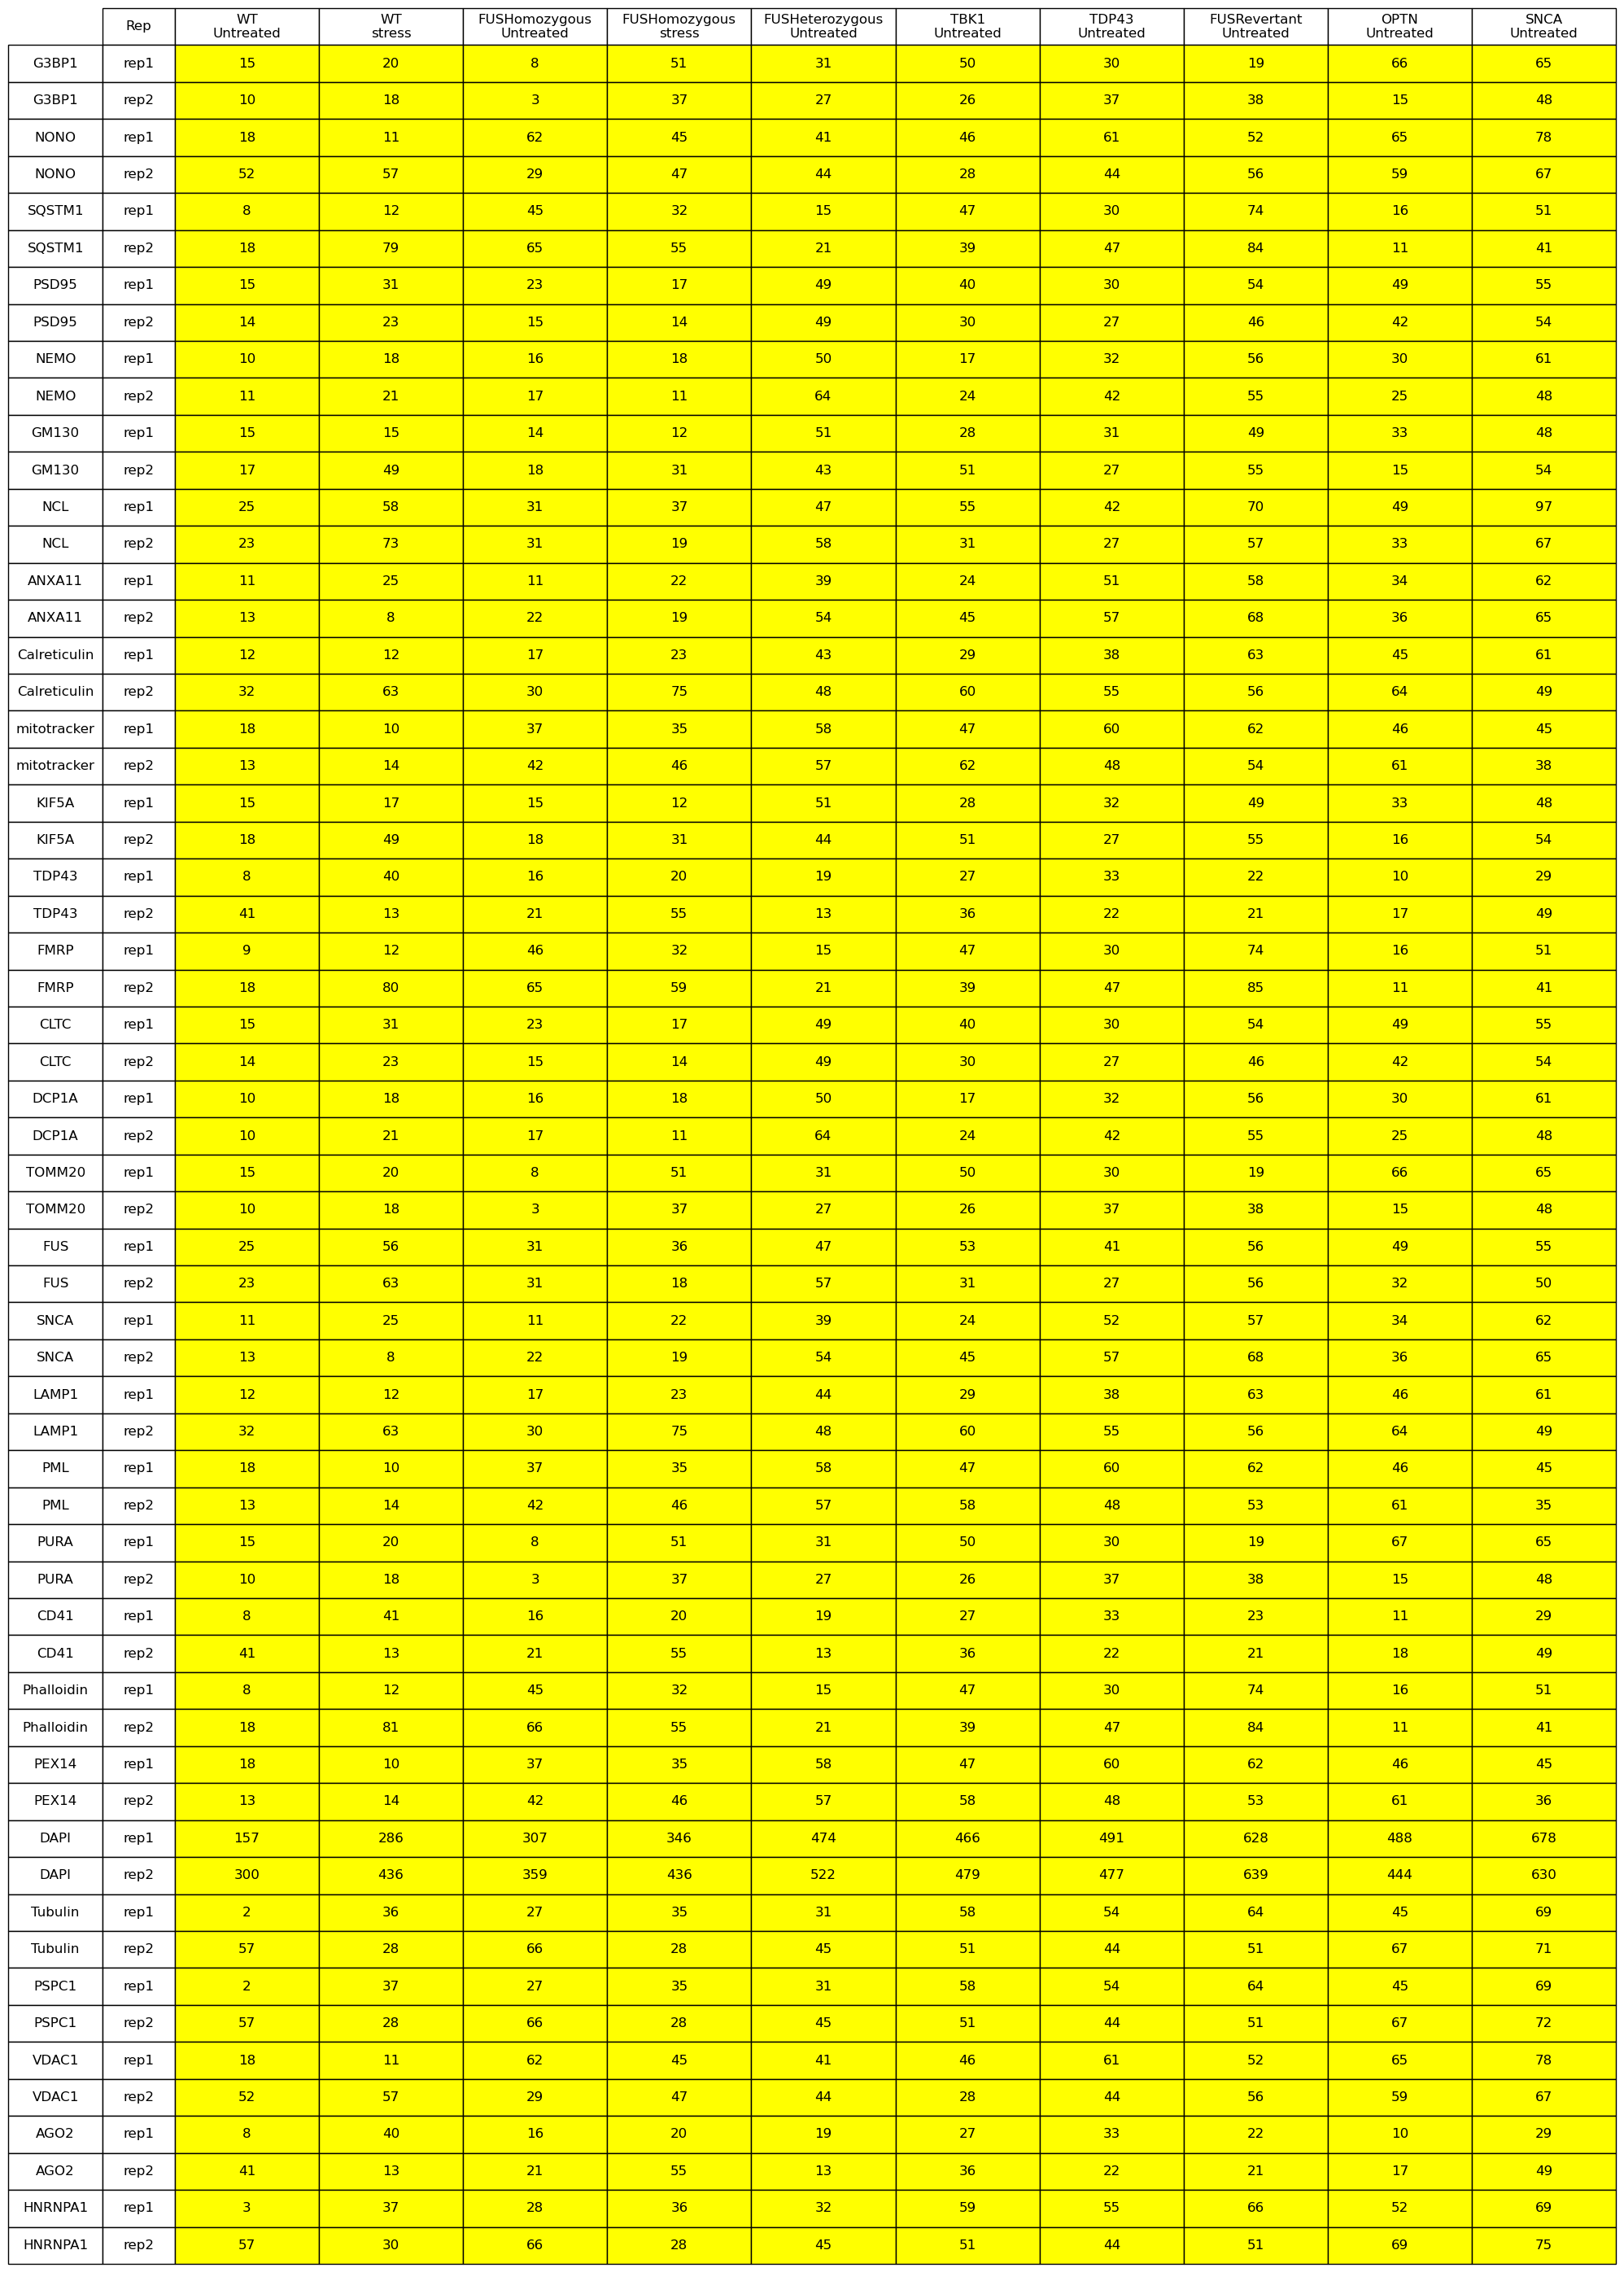

In [130]:
display_diff(batches, raws, procs, PLOT_PATH,fig_height=12)

### Variance in each batch (of processed files)

In [9]:
#for batch in list(range(3,9)) + ['7_16bit','8_16bit','9_16bit']:  

for batch in batches:
    with contextlib.redirect_stdout(io.StringIO()):
        var = sample_and_calc_variance(root_directory_proc, batch, 
                                       sample_size_per_markers=200, cond_count=2, rep_count=len(opera18days_reps), 
                                       num_markers=len(opera18days_markers))
    print(f'{batch} var: ',var)

batch1 var:  0.023519648146724494
batch2 var:  0.023363238729173504


## Preprocessing Filtering qc
By order of filtering

### 1. % site survival after Brenner on DAPI channel
Percentage out of the total sites

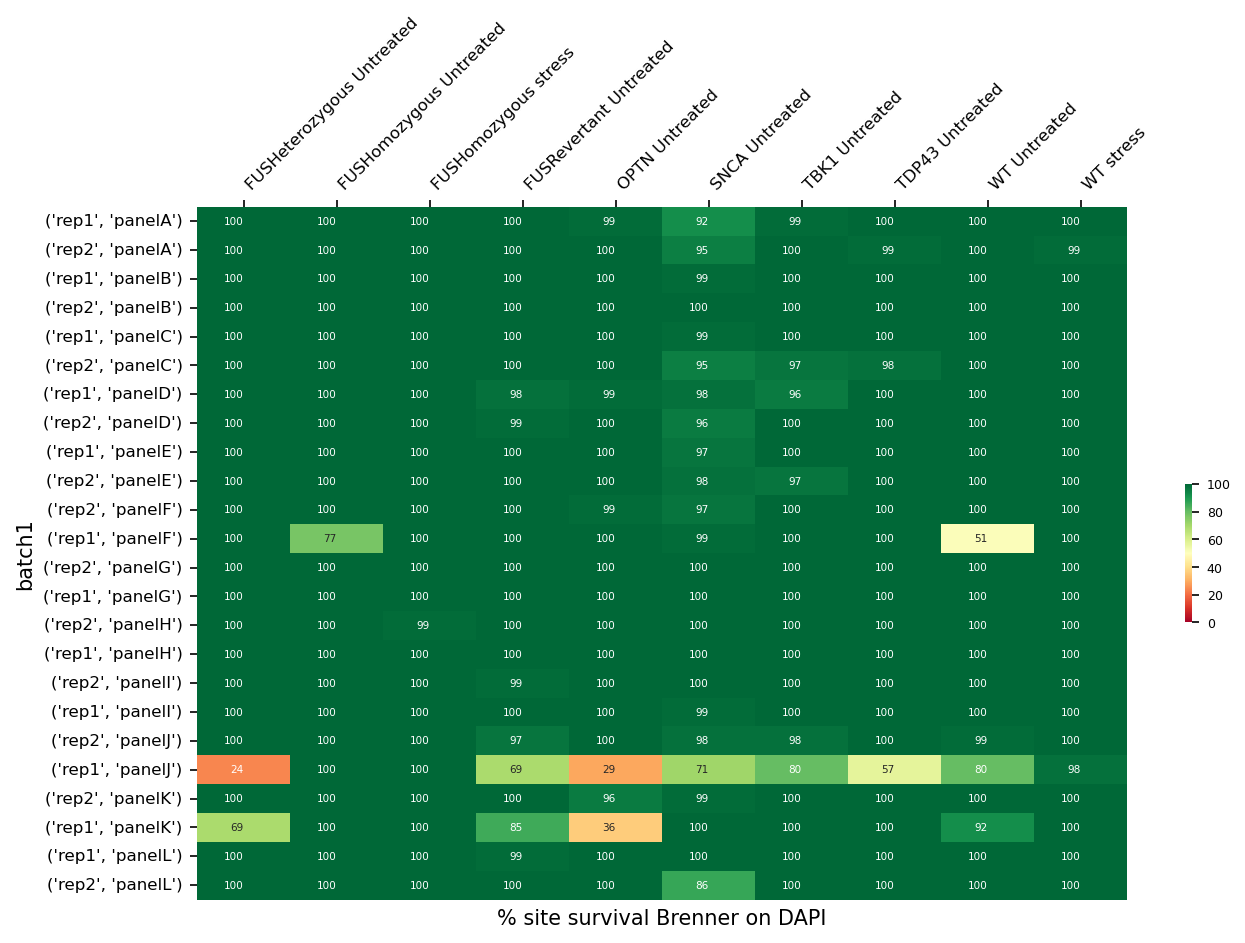

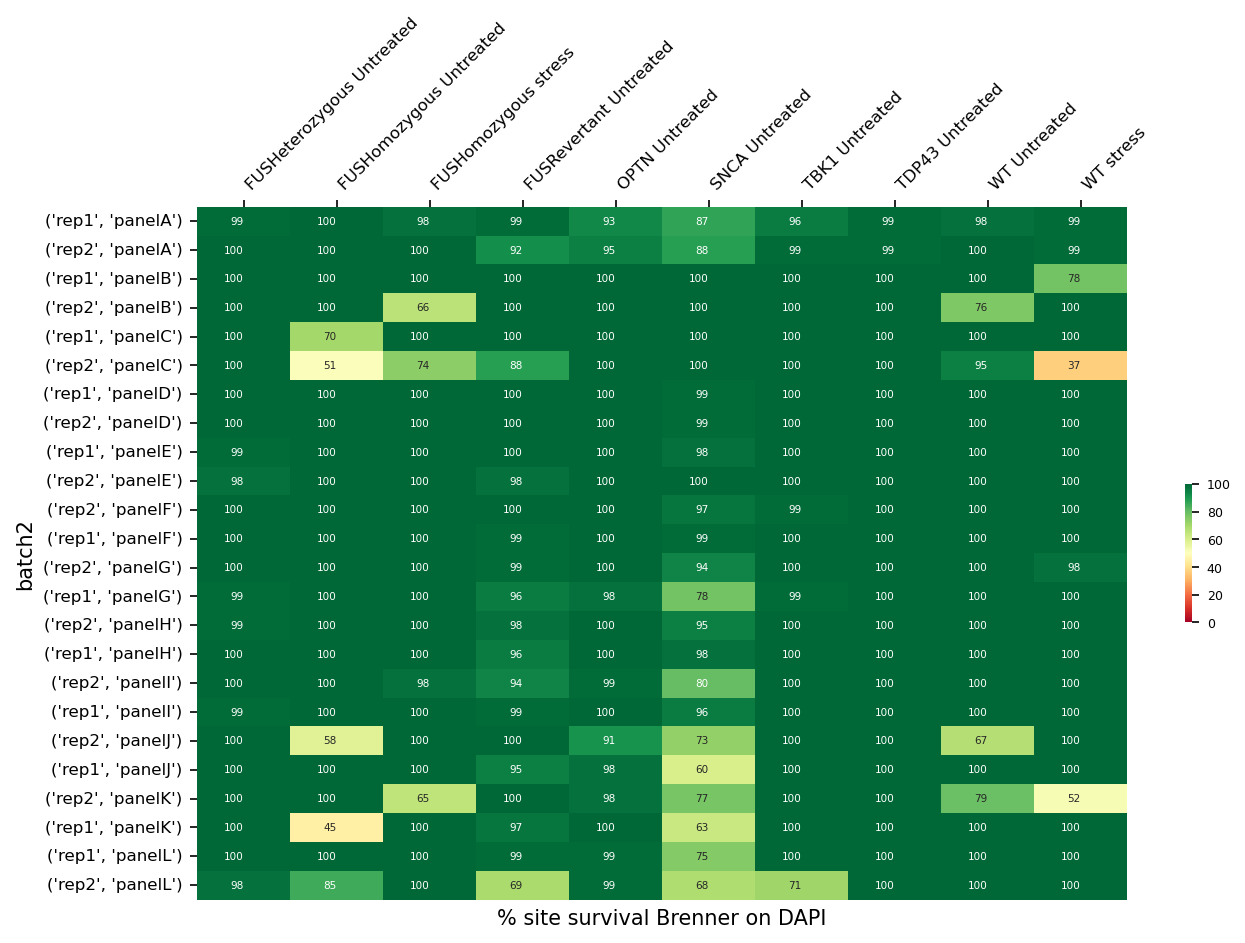

In [143]:
dapi_filter_by_brenner = show_site_survival_dapi_brenner(df_dapi,batches, opera18days_line_colors, opera18days_panels,
                                                         figsize=(10,6), reps = opera18days_reps)

### 2. % Site survival after Cellpose
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if Cellpose found 0 cells in it.**

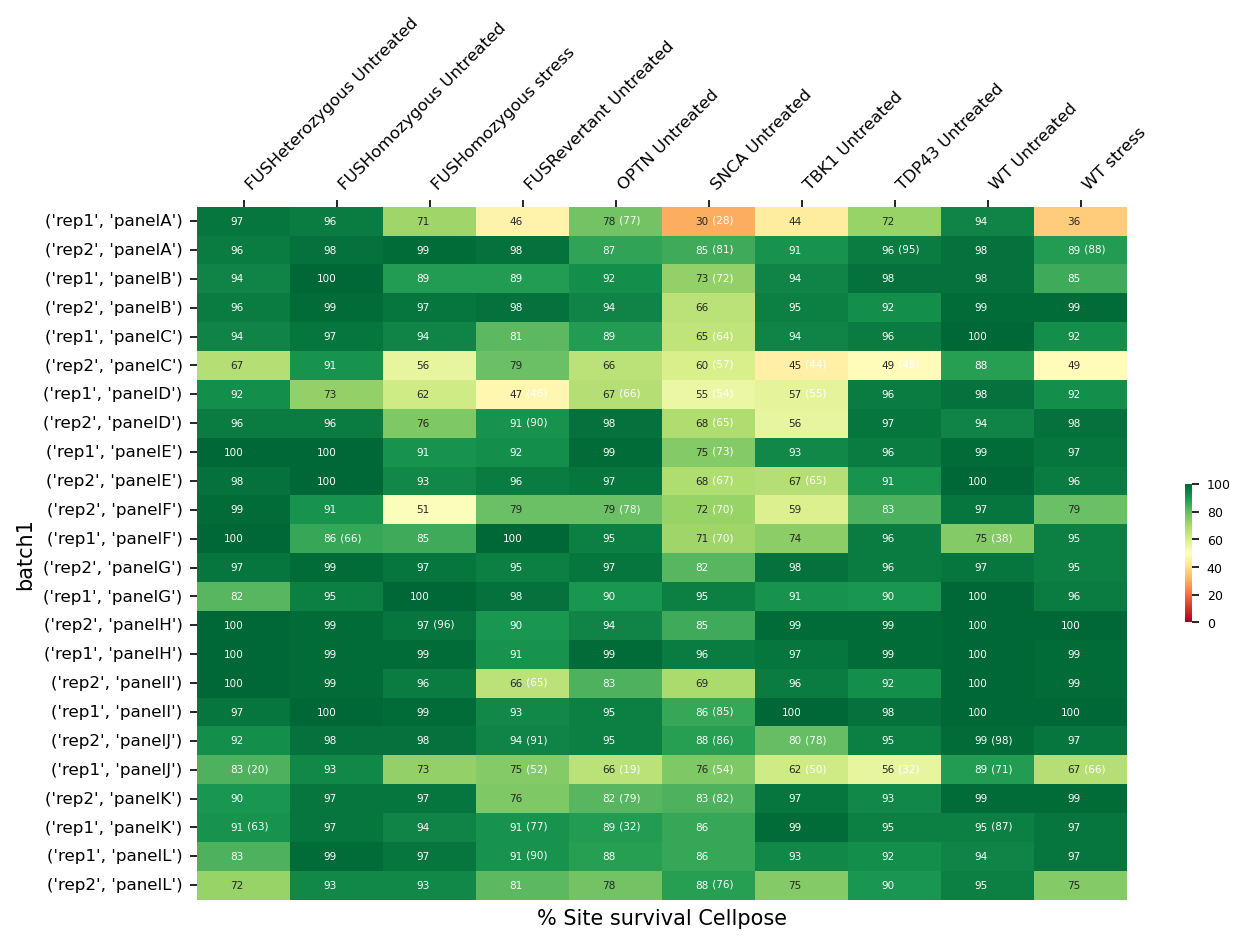

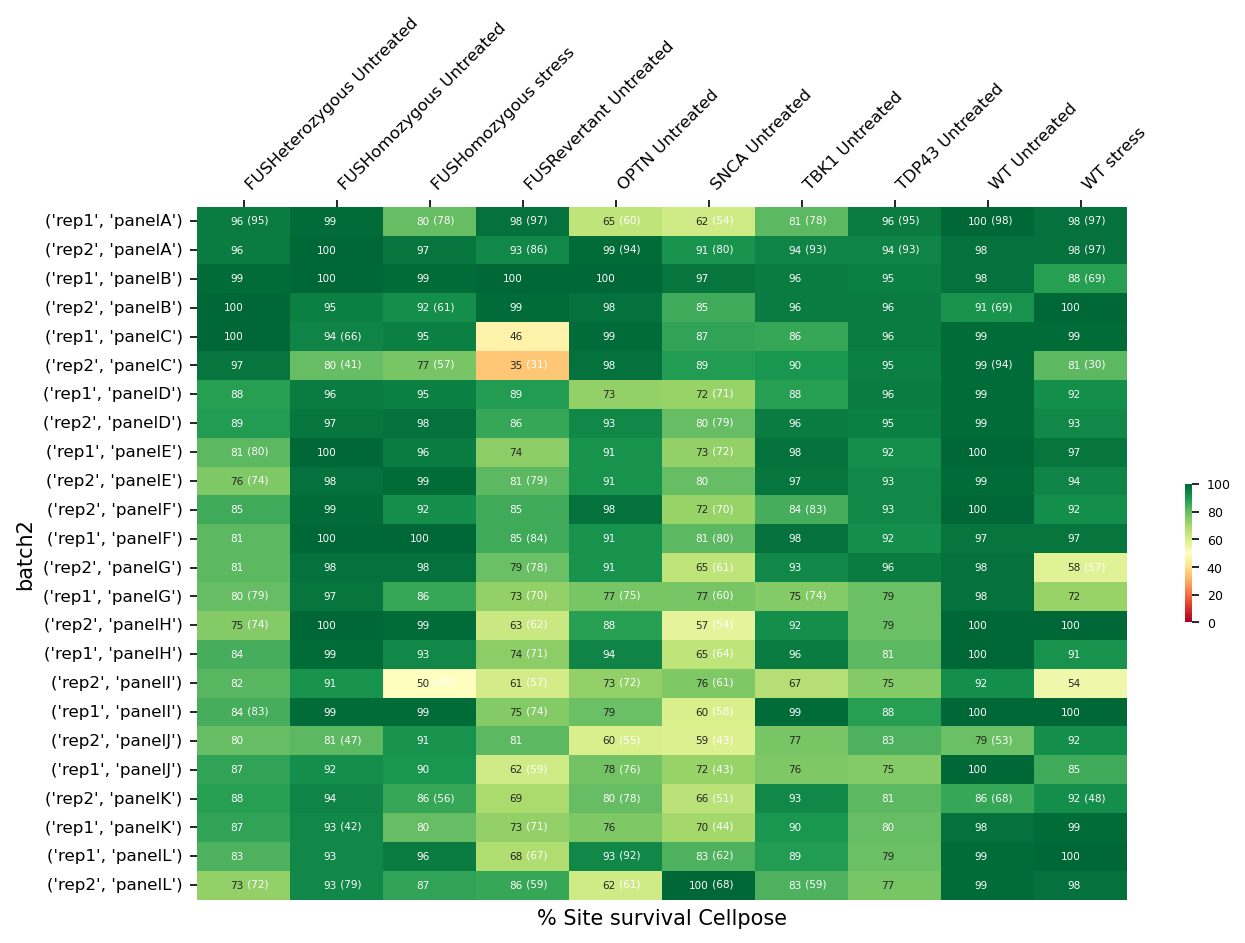

In [144]:
dapi_filter_by_cellpose = show_site_survival_dapi_cellpose(df_dapi, batches, dapi_filter_by_brenner, 
                                                           opera18days_line_colors, opera18days_panels, reps = opera18days_reps,
                                                           figsize=(10,6))

### 3. % Site survival by tiling
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if after tiling, no tile is containing at least one whole cell that Cellpose detected.**

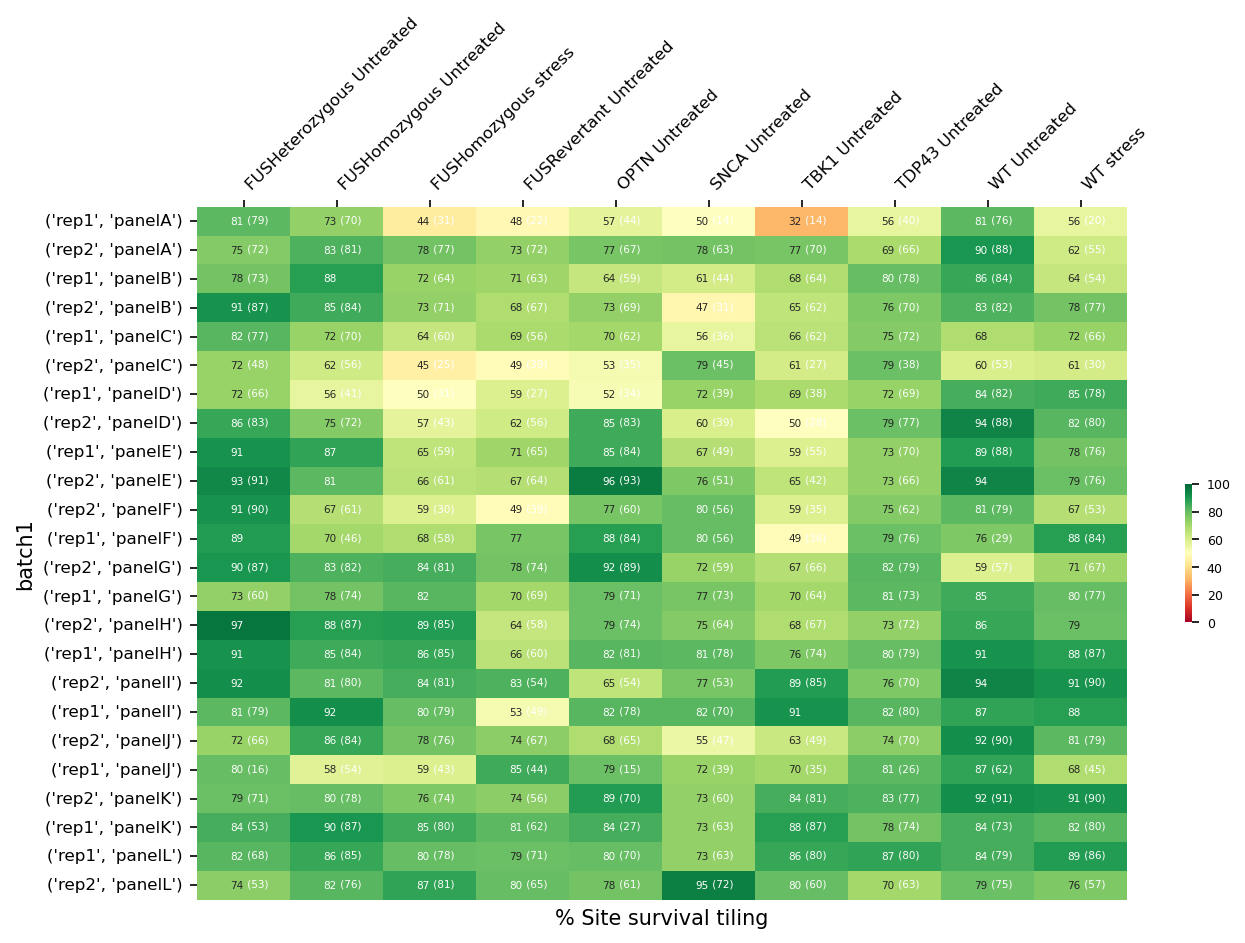

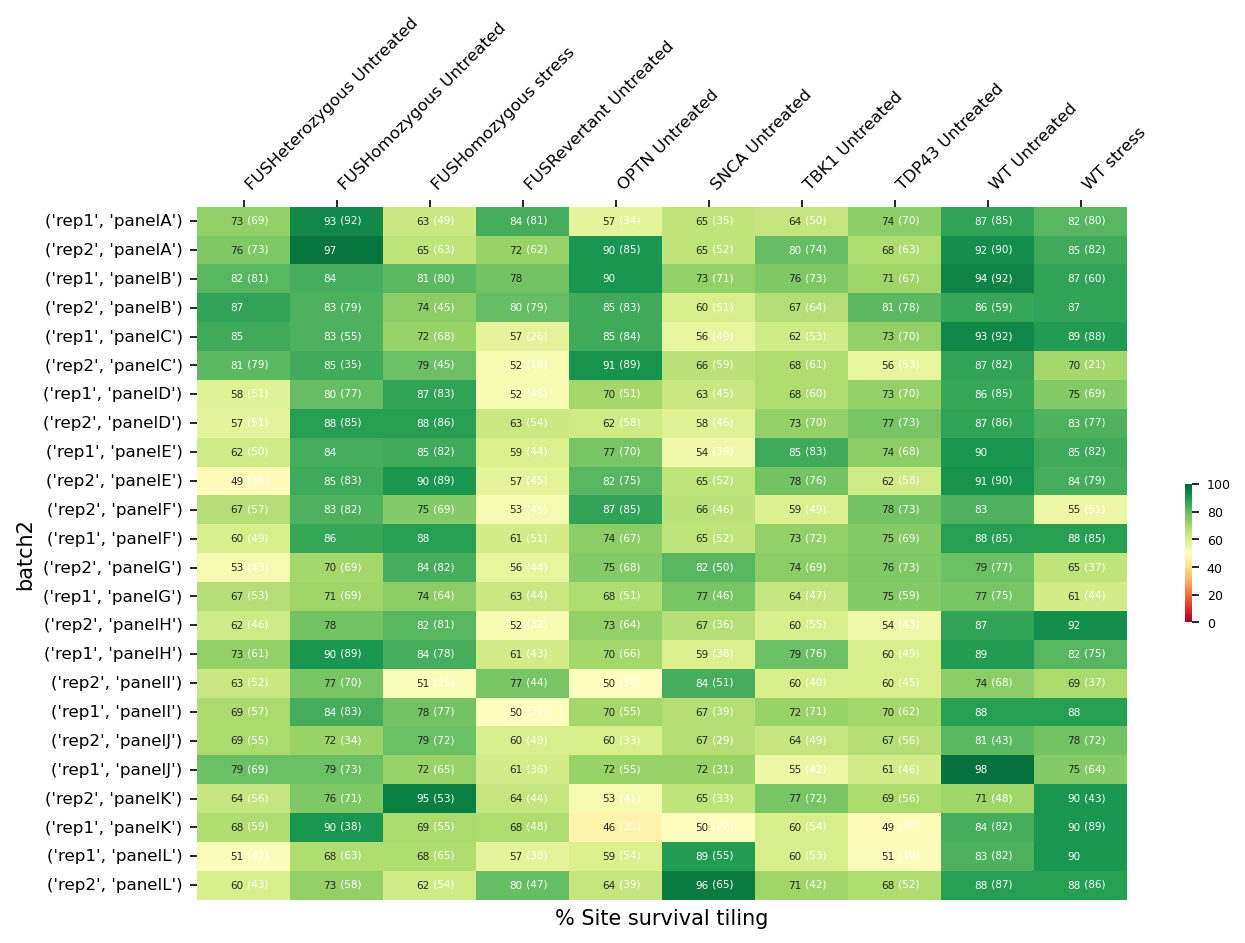

In [145]:
dapi_filter_by_tiling=show_site_survival_dapi_tiling(df_dapi, batches, dapi_filter_by_cellpose, 
                                                     opera18days_line_colors, opera18days_panels, figsize=(10,6),
                                                     reps = opera18days_reps)

### 4. % Site survival after Brenner on target channel
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values (if different than the percentages).

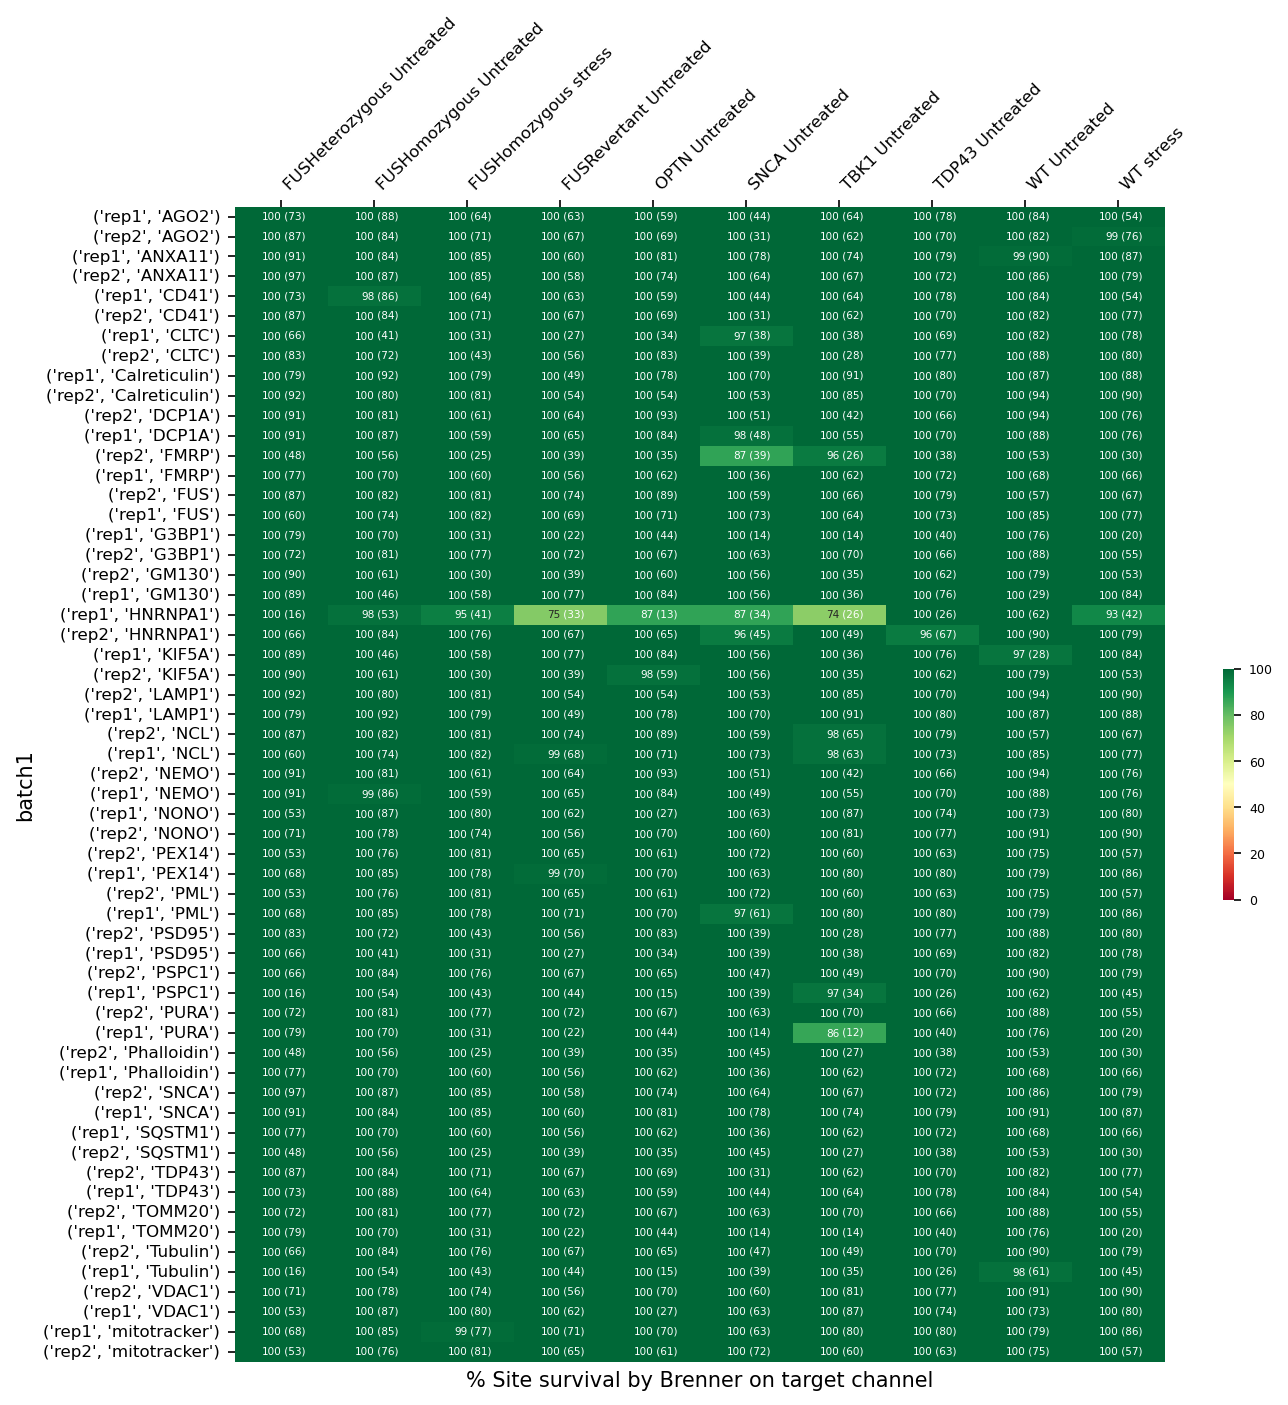

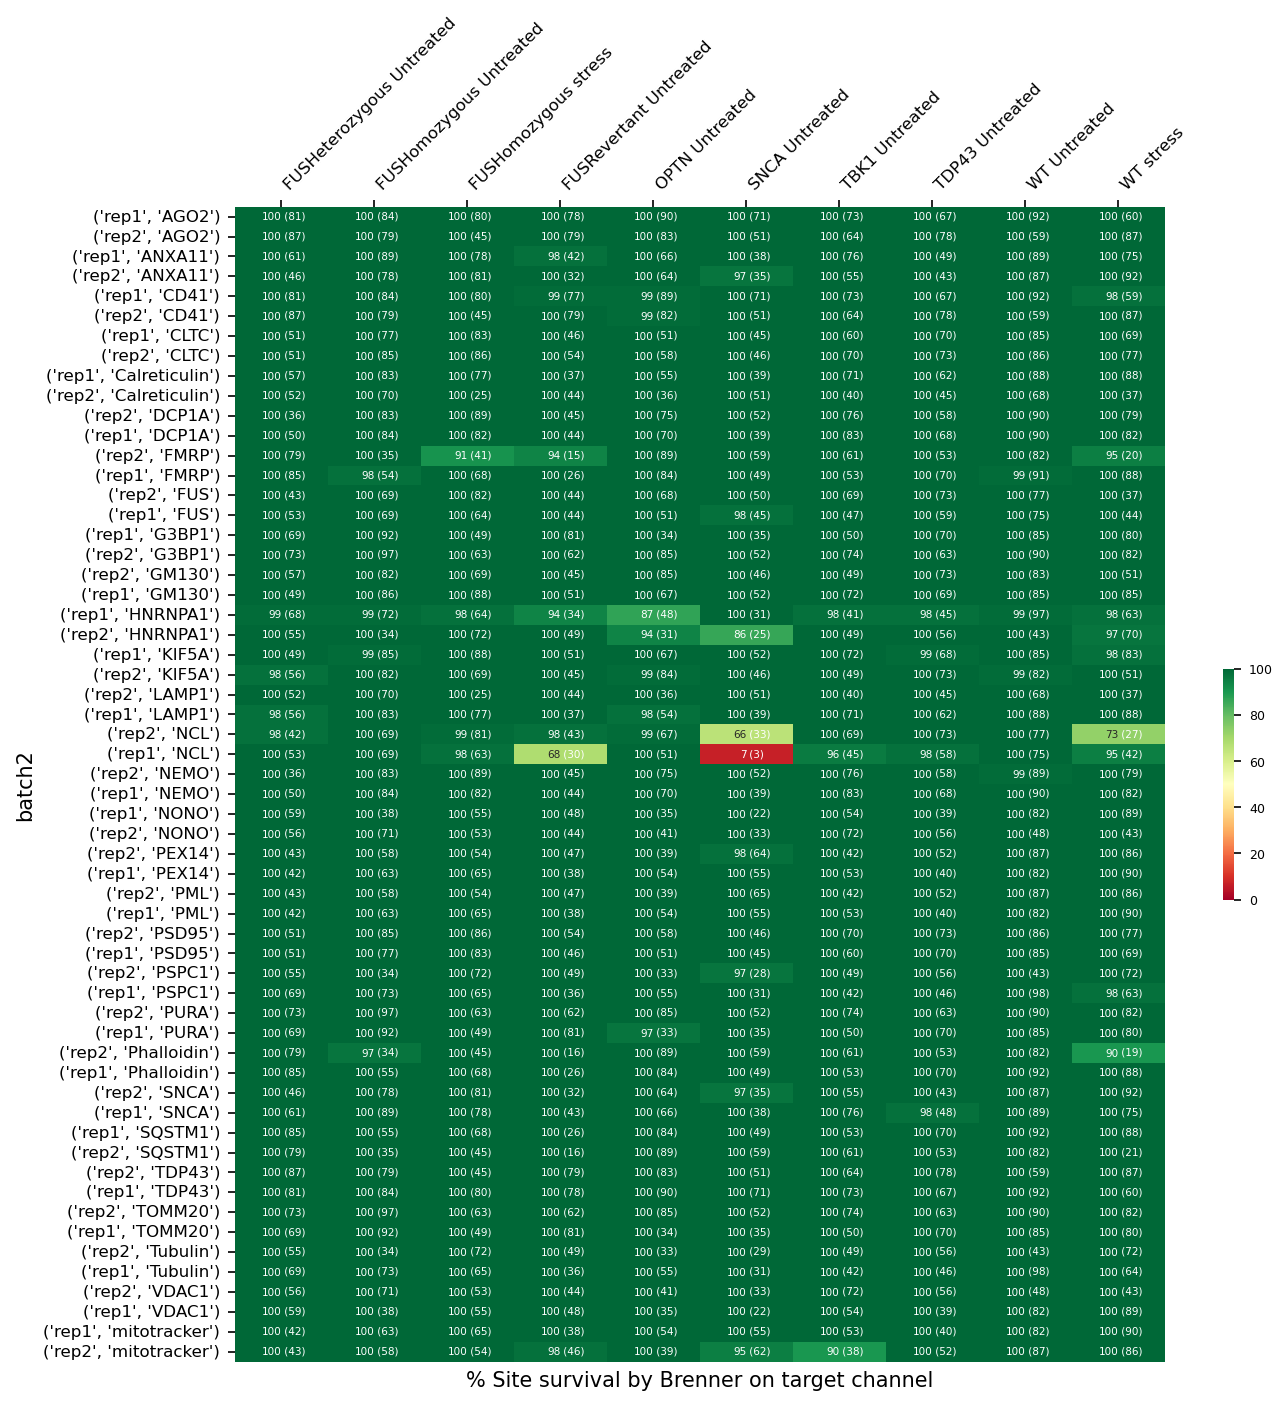

In [146]:
show_site_survival_target_brenner(df_dapi, df_target, dapi_filter_by_tiling,
                                 figsize=(10,10), markers=opera18days_markers)

## Statistics About the Processed Files

In [147]:
names = ['Total number of tiles', 'Total number of whole cells']
stats = ['n_valid_tiles','site_whole_cells_counts_sum','site_cell_count','site_cell_count_sum']
total_sum = calc_total_sums(df_target, df_dapi, stats, opera18days_markers)

### Total tiles

In [164]:
## Are we using FMRP?
markers_for_d18 = markers.copy()
markers_for_d18.remove('DAPI')
markers_for_d18.remove('TIA1')
total_sum[total_sum.marker.isin(markers_for_d18)].n_valid_tiles.sum()

144424

### Total Dapi tiles


In [149]:
total_sum[total_sum.marker == 'DAPI'].n_valid_tiles.sum()

74116

### Total neurons

In [159]:
total_sum[total_sum.marker.isin(markers_for_d18)].site_cell_count_sum.sum()

894423.0

### Total Dapi neurons

In [160]:
total_sum[total_sum.marker == 'DAPI'].site_cell_count_sum.sum()

526900.0

In [152]:
show_total_sum_tables(total_sum)

### Show Total Tile Counts
For each batch, cell line, replicate and markerTotal number of tiles

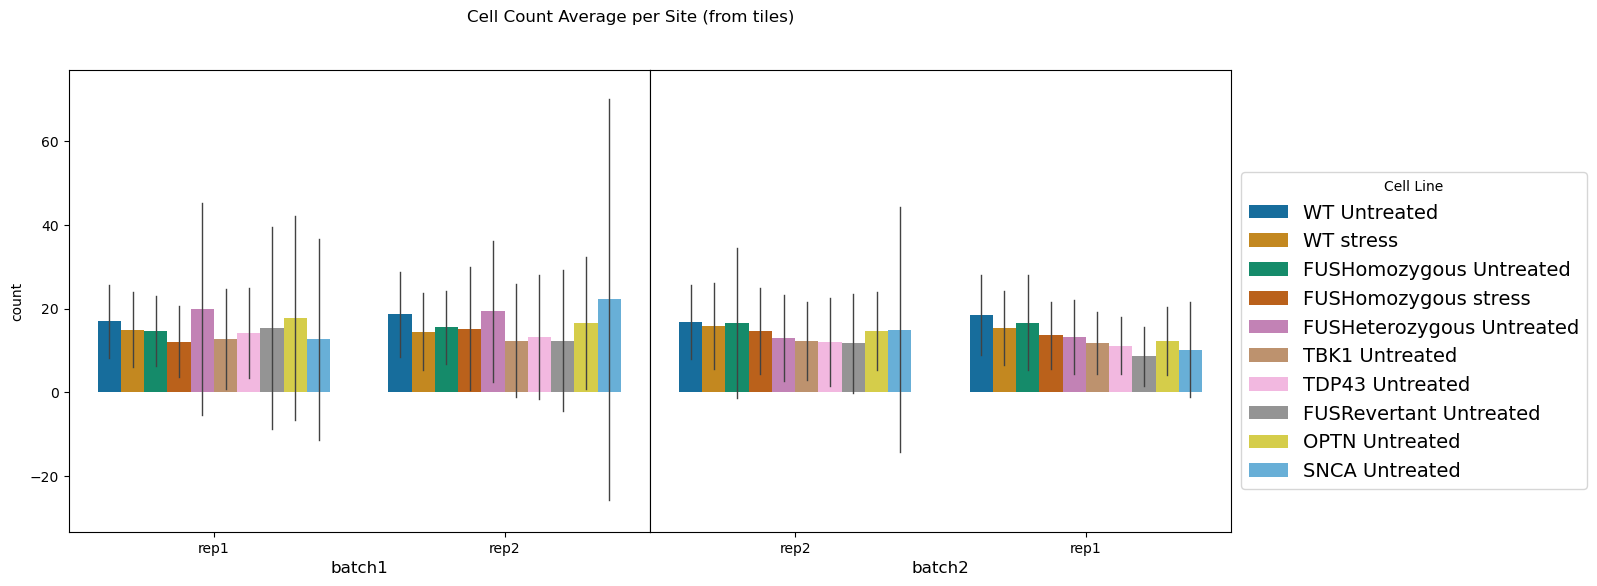

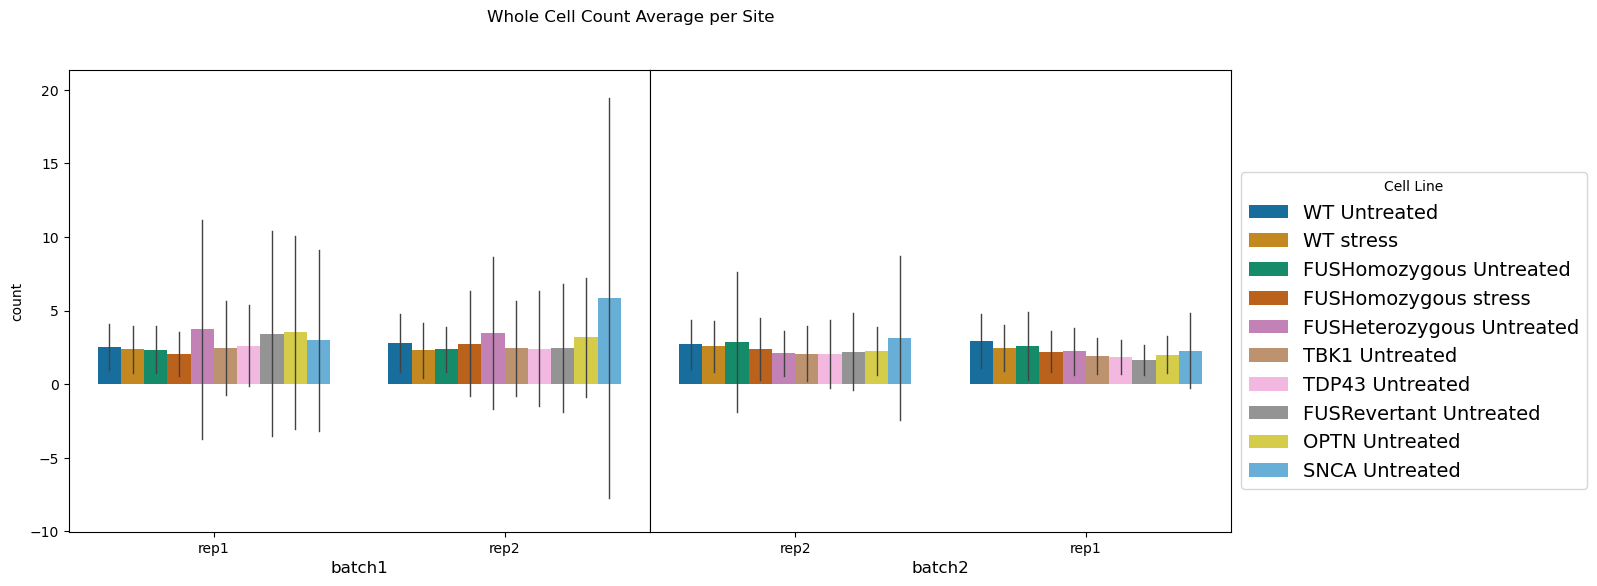

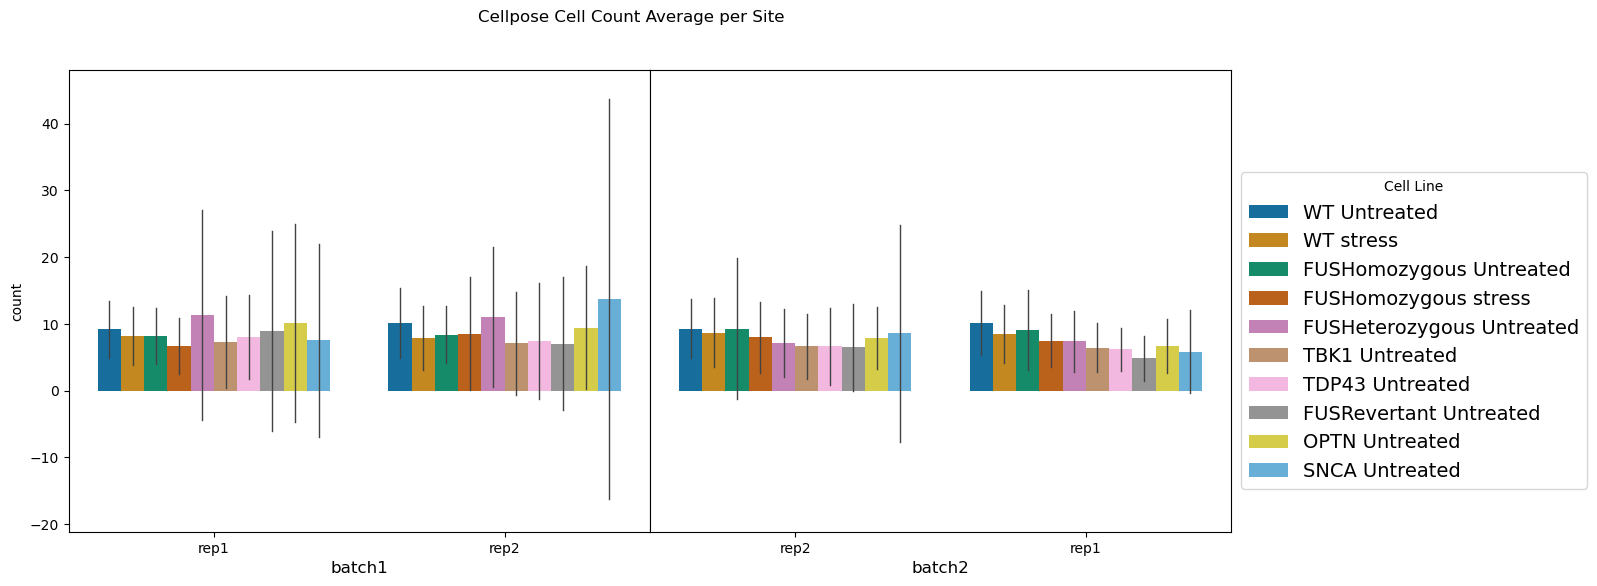

In [185]:
df_no_empty_sites = df_dapi[df_dapi.n_valid_tiles !=0]
plot_cell_count(df_no_empty_sites, opera18days_lines_order, opera18days_custom_palette, y='site_cell_count_sum', 
                title='Cell Count Average per Site (from tiles)')

plot_cell_count(df_no_empty_sites, opera18days_lines_order, opera18days_custom_palette, y='site_whole_cells_counts_sum',
                title='Whole Cell Count Average per Site')

plot_cell_count(df_no_empty_sites, opera18days_lines_order, opera18days_custom_palette, y='site_cell_count',
               title='Cellpose Cell Count Average per Site')

### Show **Cell Count** Statistics per Batch

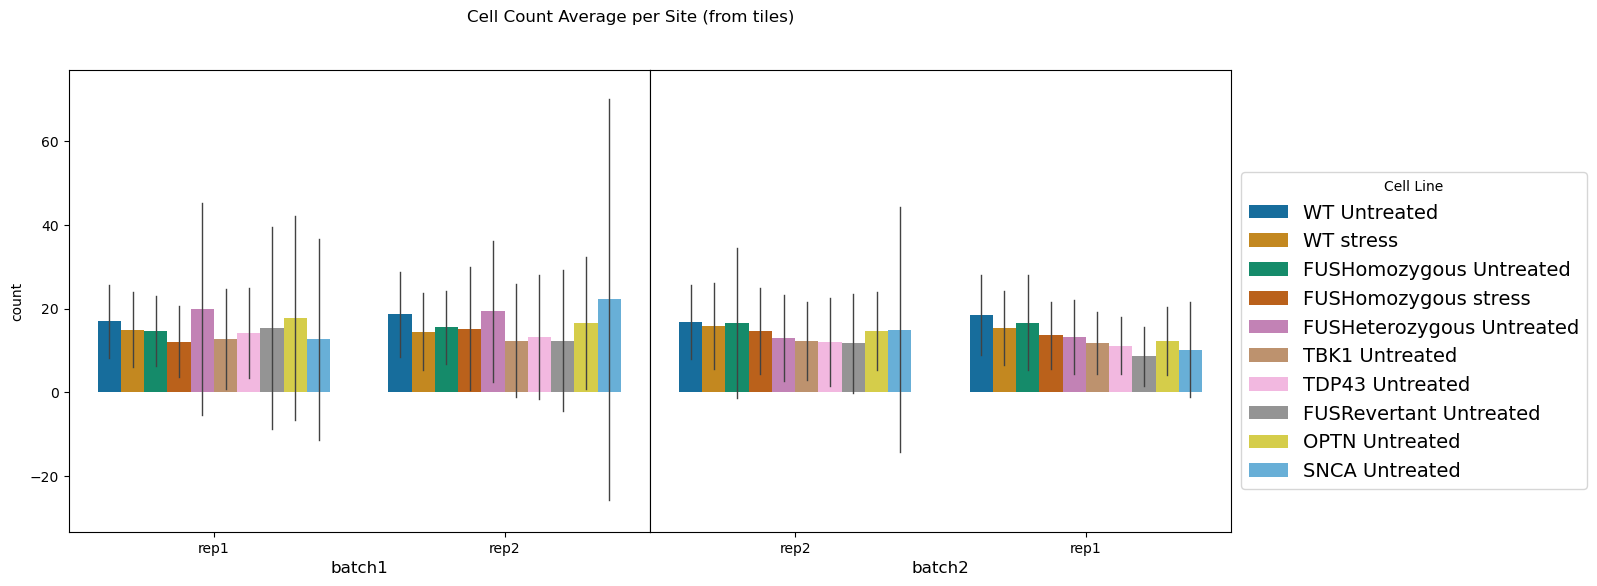

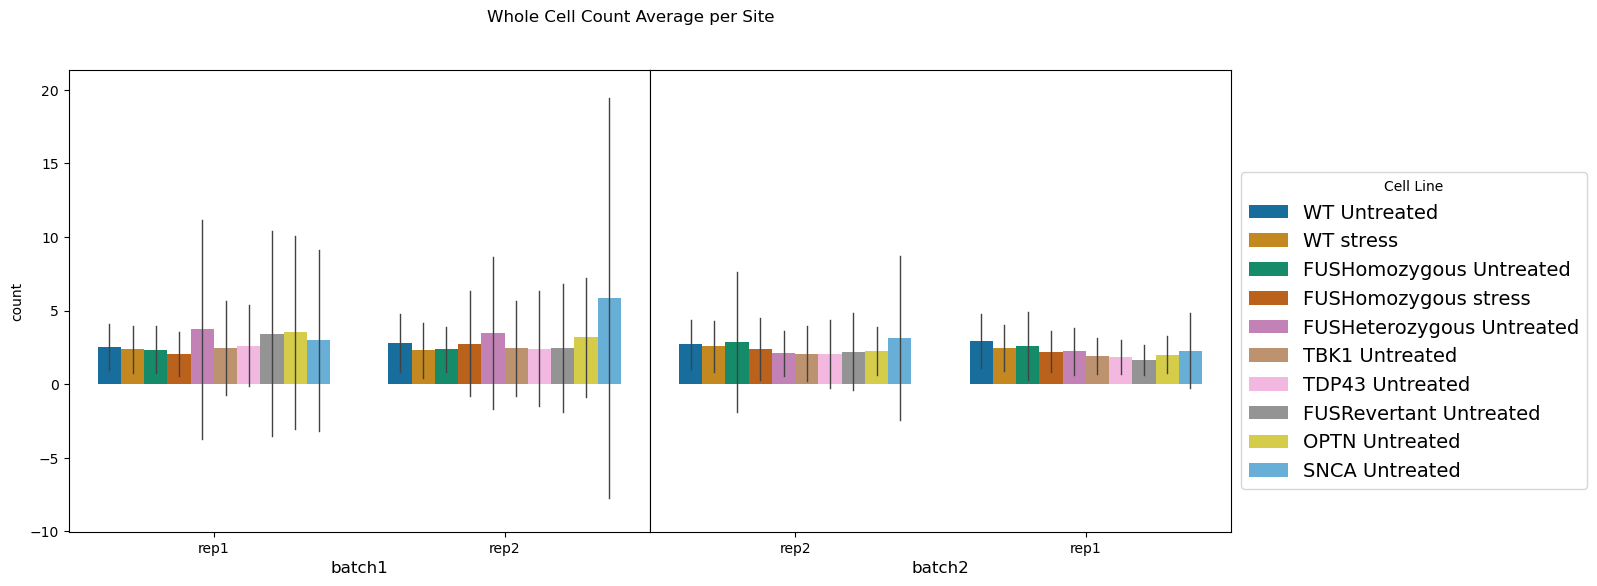

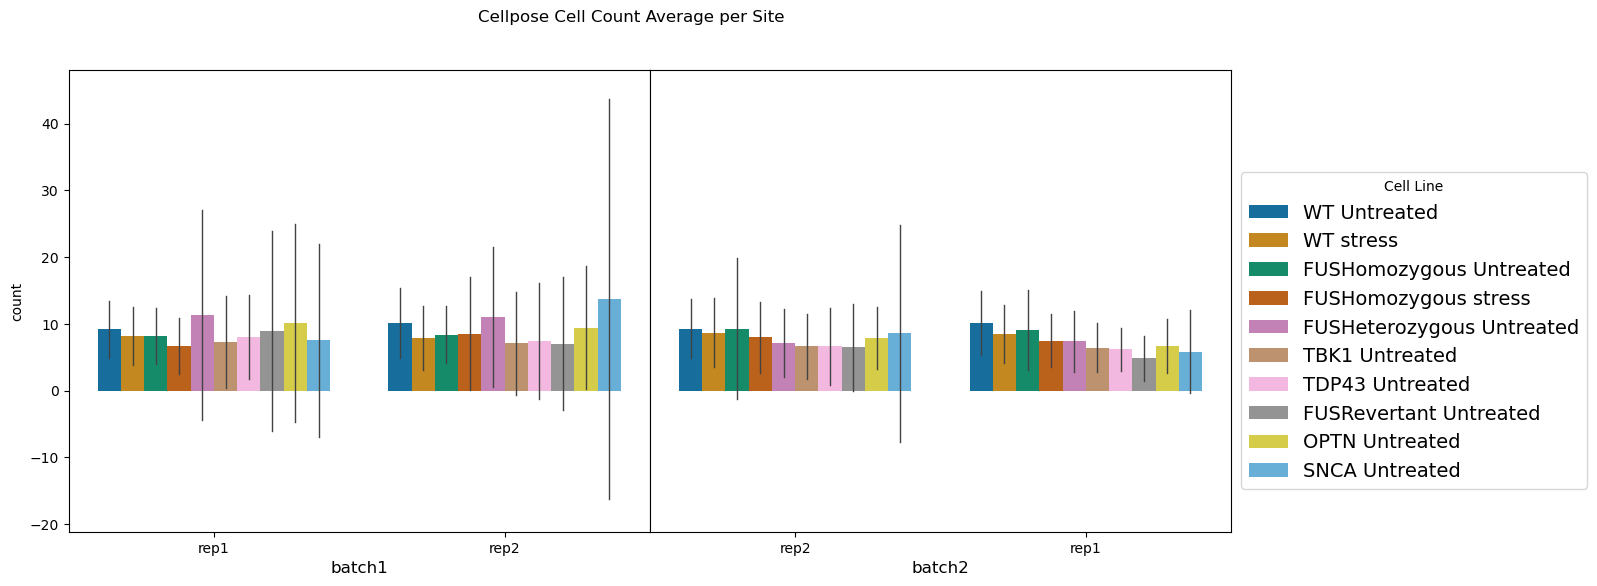

In [185]:
df_no_empty_sites = df_dapi[df_dapi.n_valid_tiles !=0]
plot_cell_count(df_no_empty_sites, opera18days_lines_order, opera18days_custom_palette, y='site_cell_count_sum', 
                title='Cell Count Average per Site (from tiles)')

plot_cell_count(df_no_empty_sites, opera18days_lines_order, opera18days_custom_palette, y='site_whole_cells_counts_sum',
                title='Whole Cell Count Average per Site')

plot_cell_count(df_no_empty_sites, opera18days_lines_order, opera18days_custom_palette, y='site_cell_count',
               title='Cellpose Cell Count Average per Site')


### Show **Tiles** per Site Statistics


In [186]:
df_dapi.groupby(['cell_line_cond']).n_valid_tiles.mean()

cell_line_cond
FUSHeterozygous Untreated    1.802519
FUSHomozygous Untreated      1.866768
FUSHomozygous stress         1.528936
FUSRevertant Untreated       1.170026
OPTN Untreated               1.621651
SNCA Untreated               1.443494
TBK1 Untreated               1.256183
TDP43 Untreated              1.368266
WT Untreated                 2.208756
WT stress                    1.687768
Name: n_valid_tiles, dtype: float64

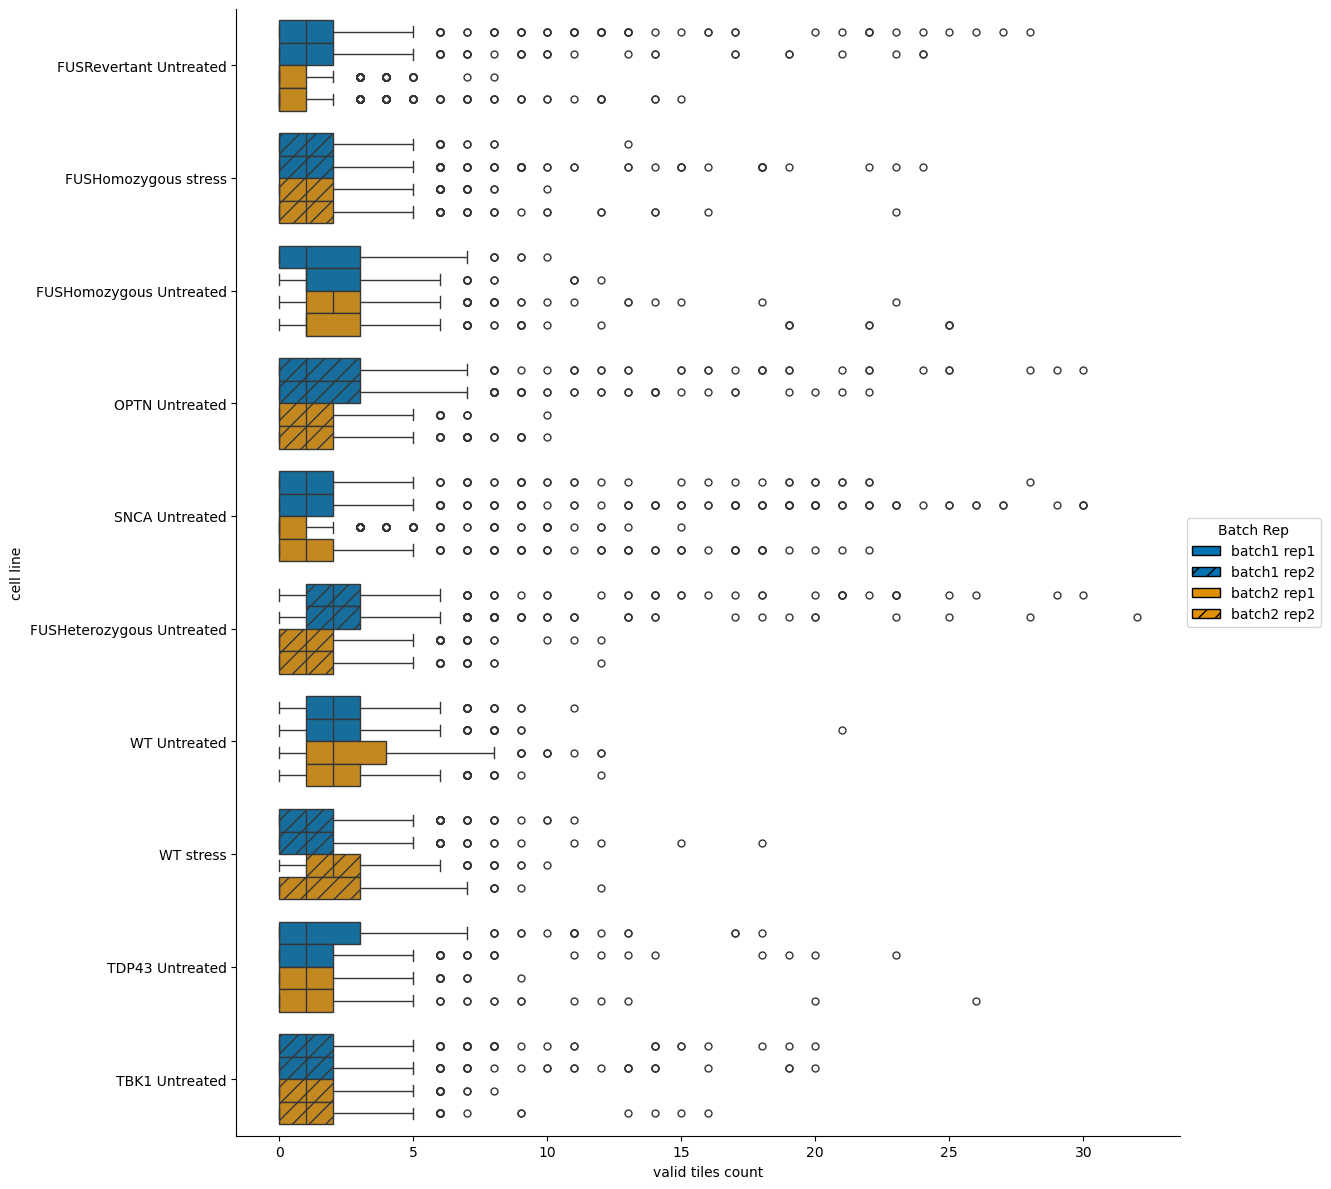

In [192]:
plot_catplot(df_dapi, opera18days_custom_palette, opera18days_reps, 
             x='n_valid_tiles', x_title='valid tiles count', batch_min=1, batch_max=2)


### Show Mean of cell count in valid tiles

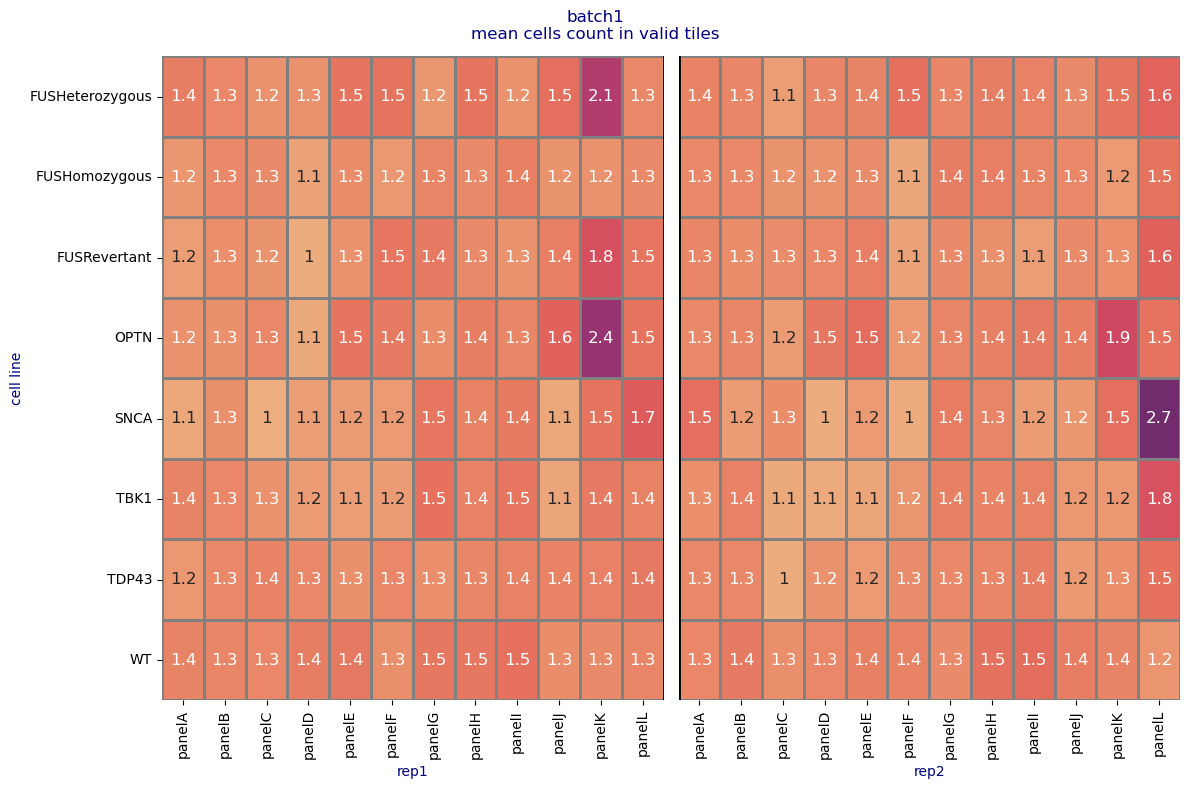

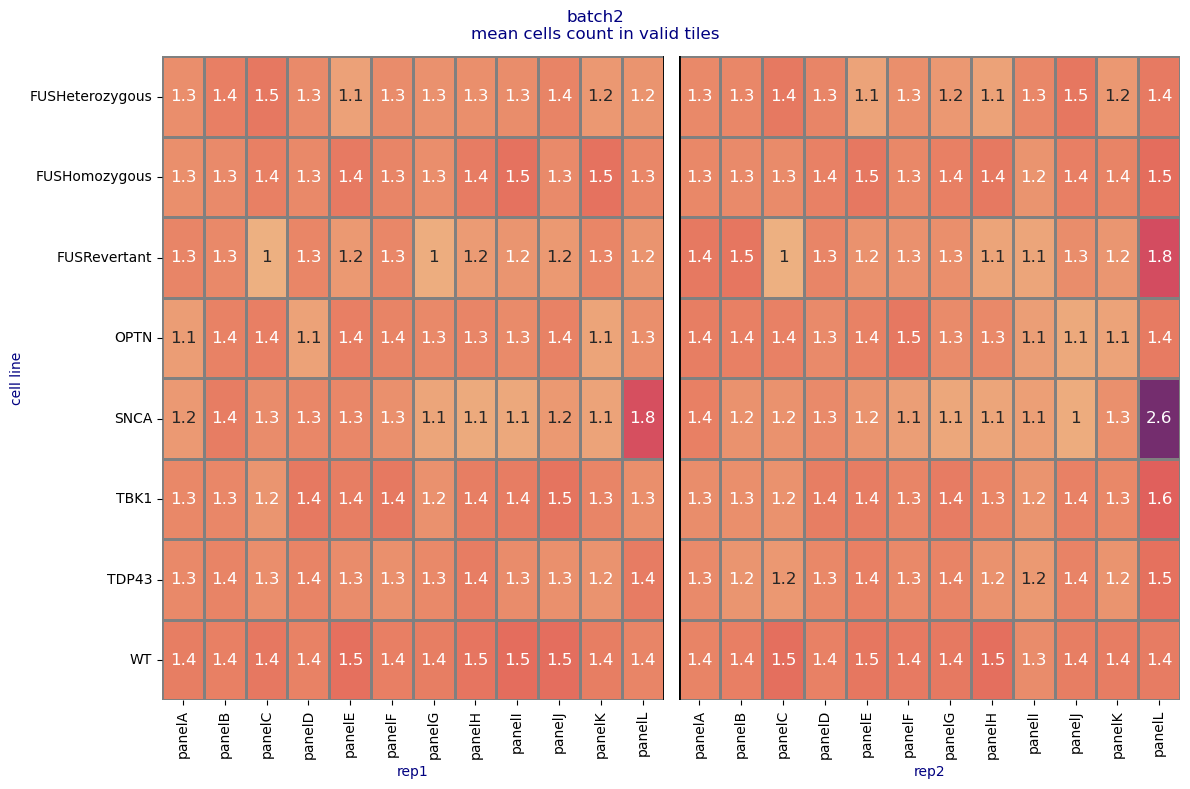

In [193]:
plot_hm(df_dapi, split_by='rep', rows='cell_line', columns='panel')

# Assessing Staining Reproducibility and Outliers

batch1


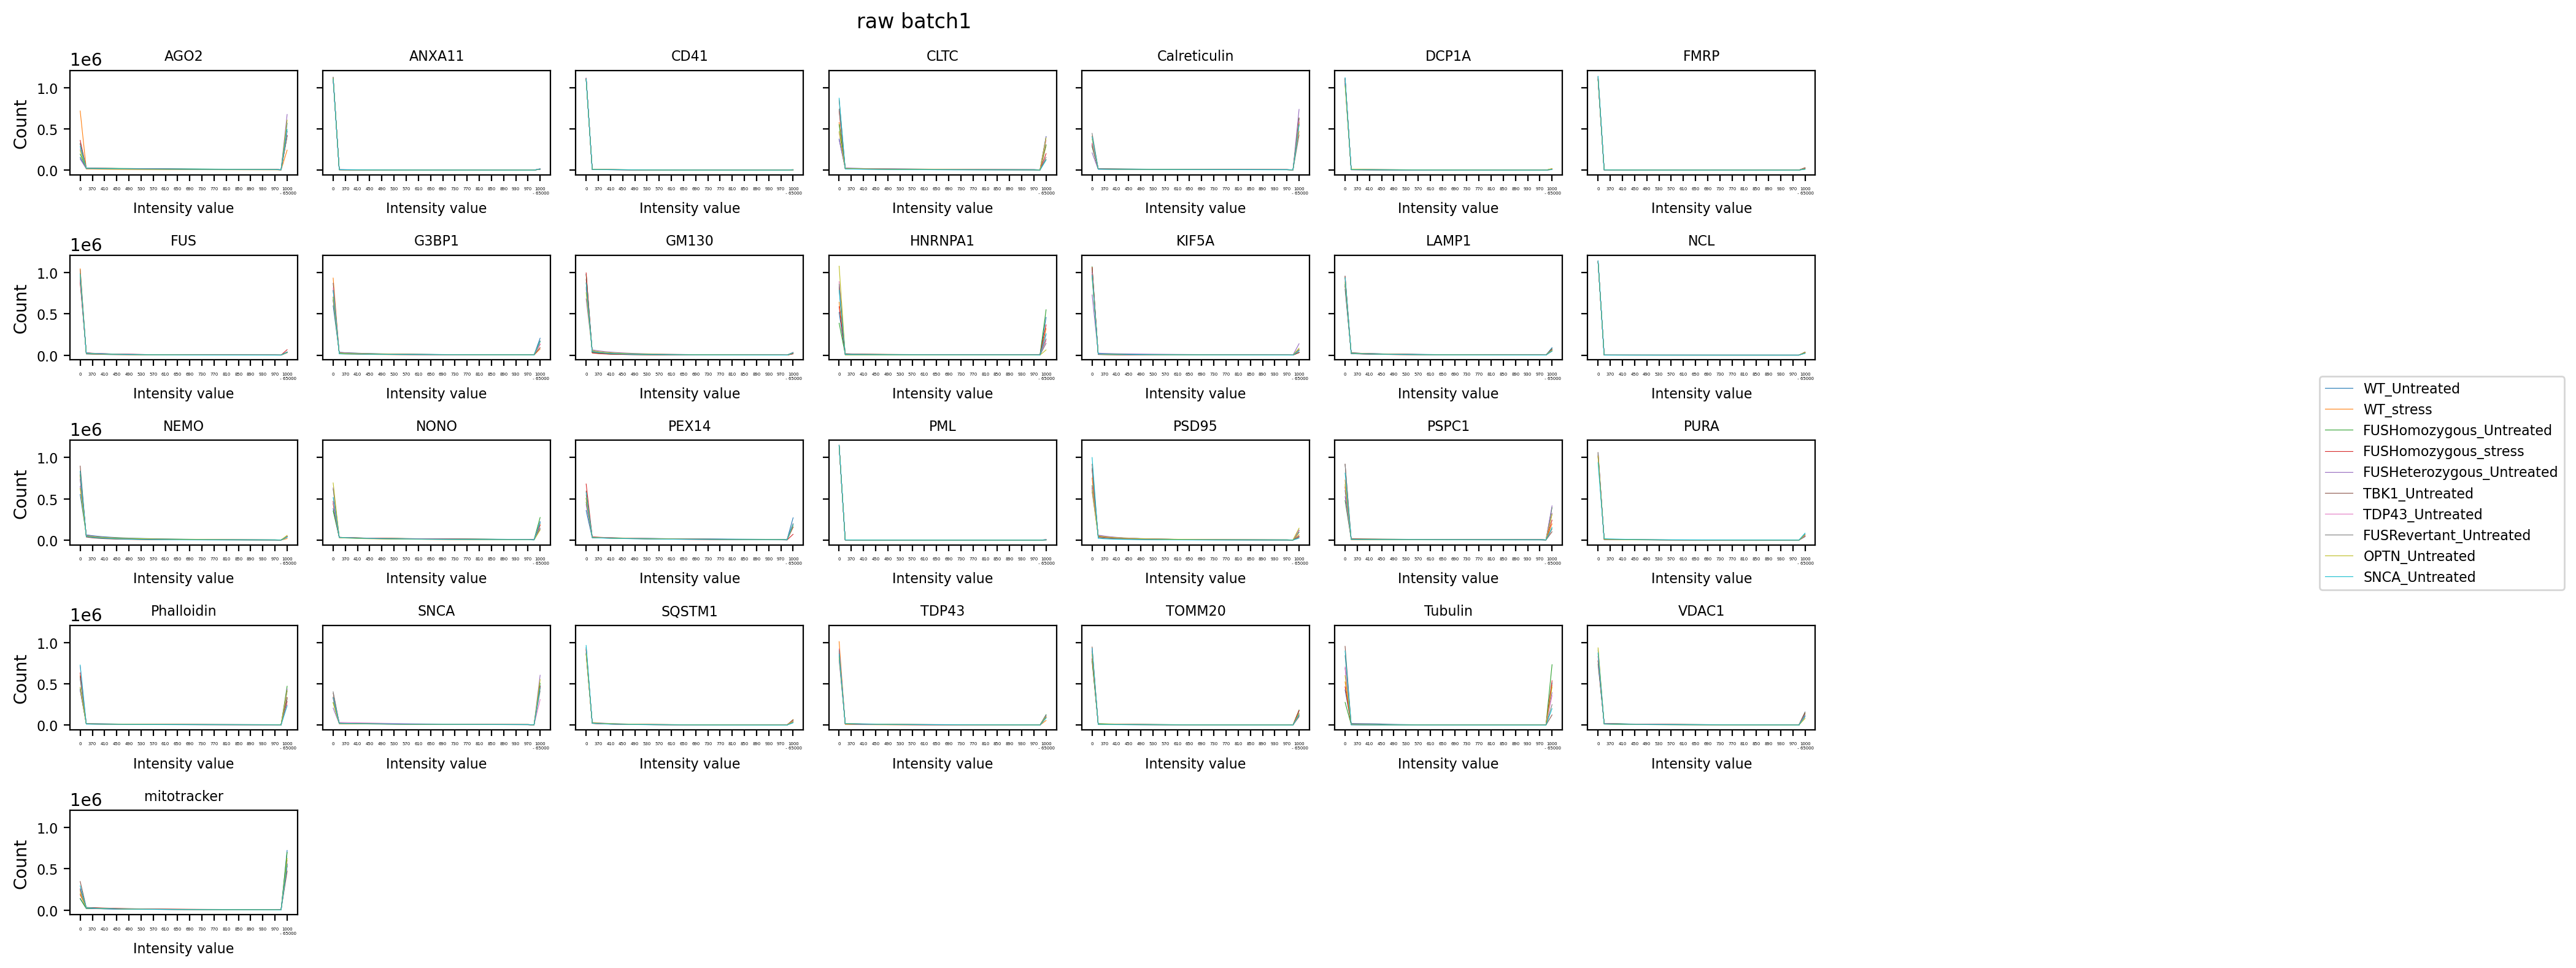

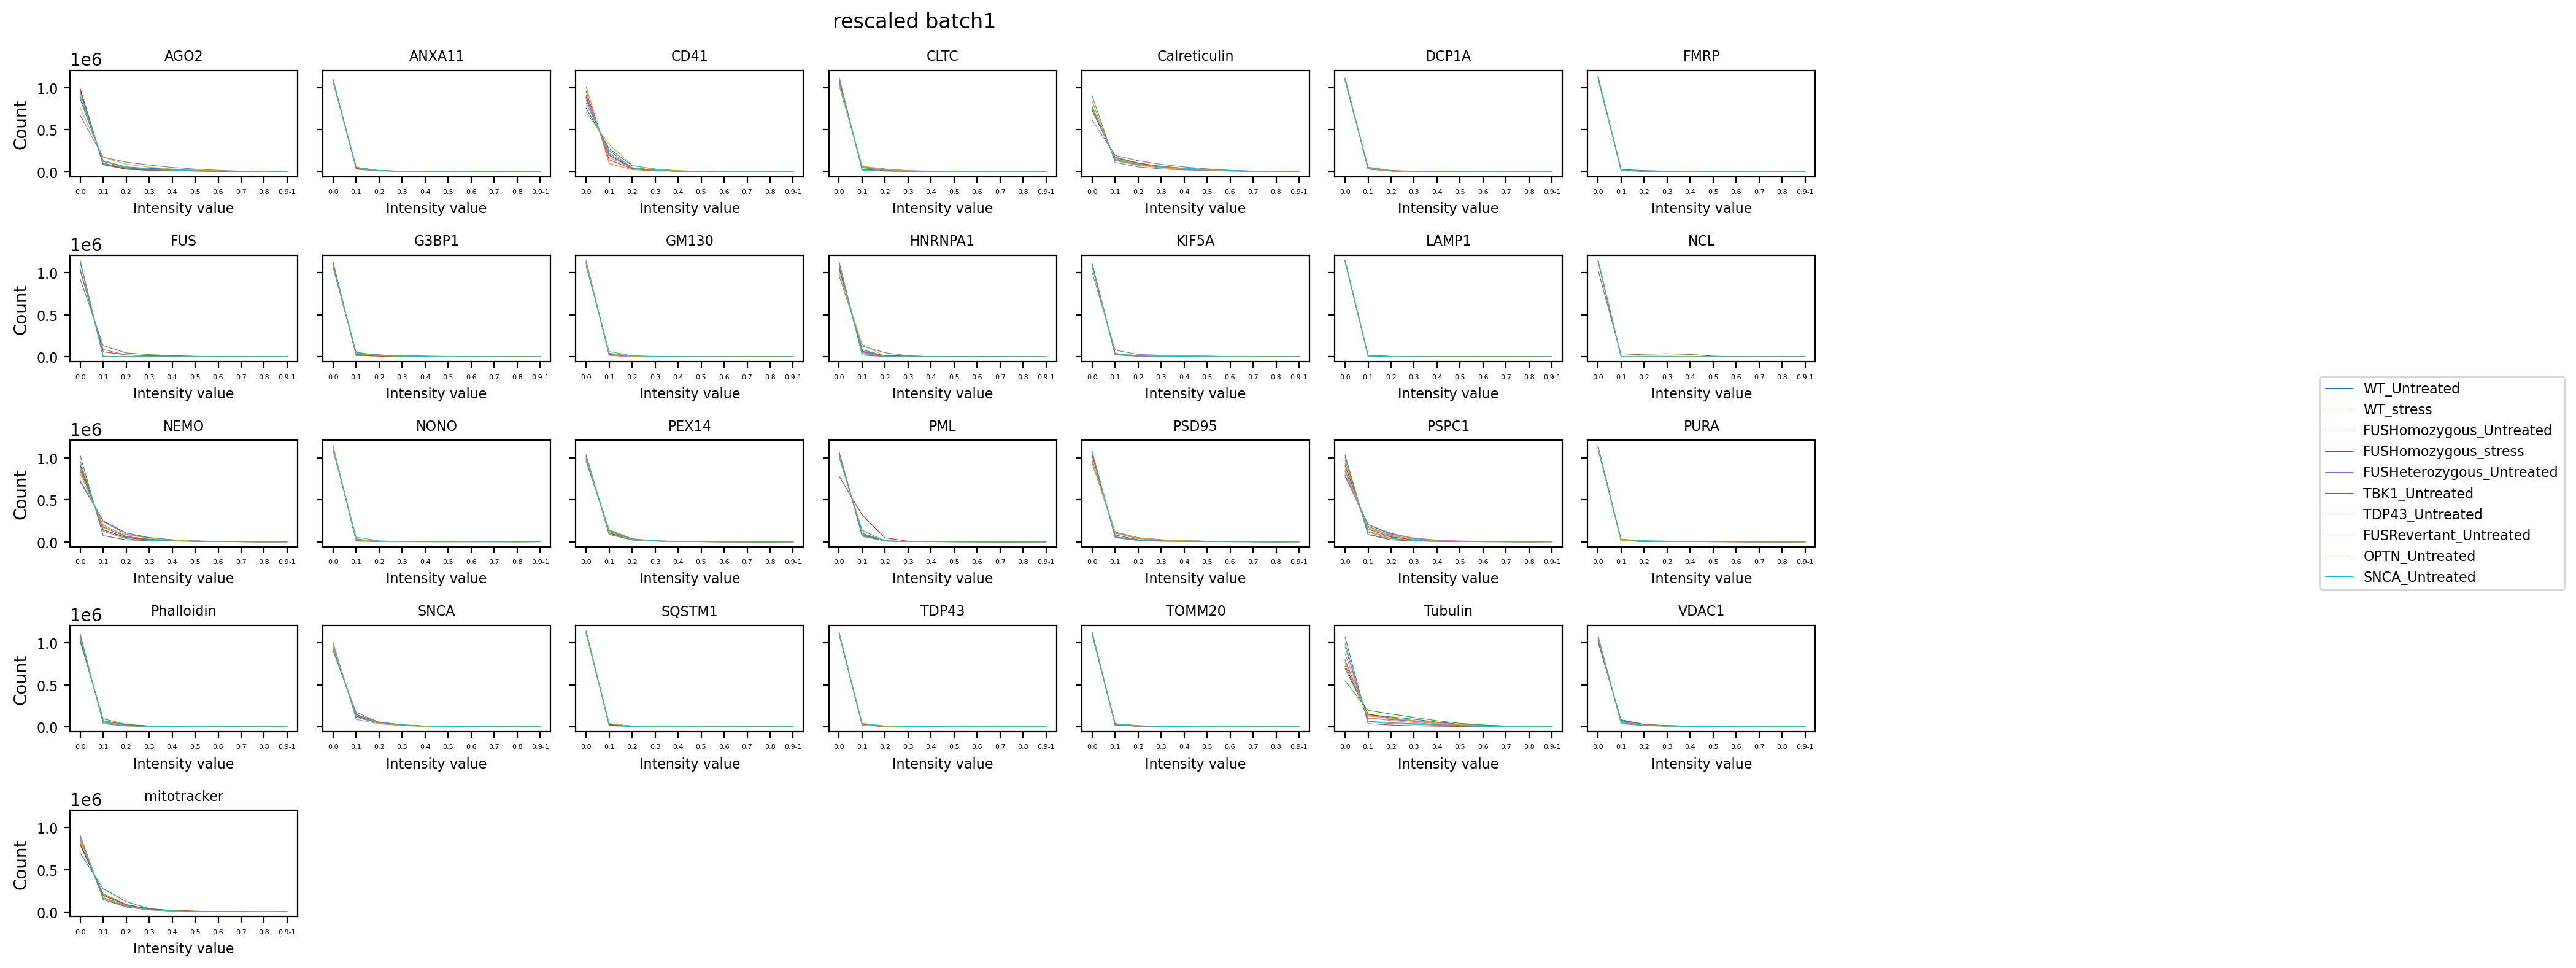

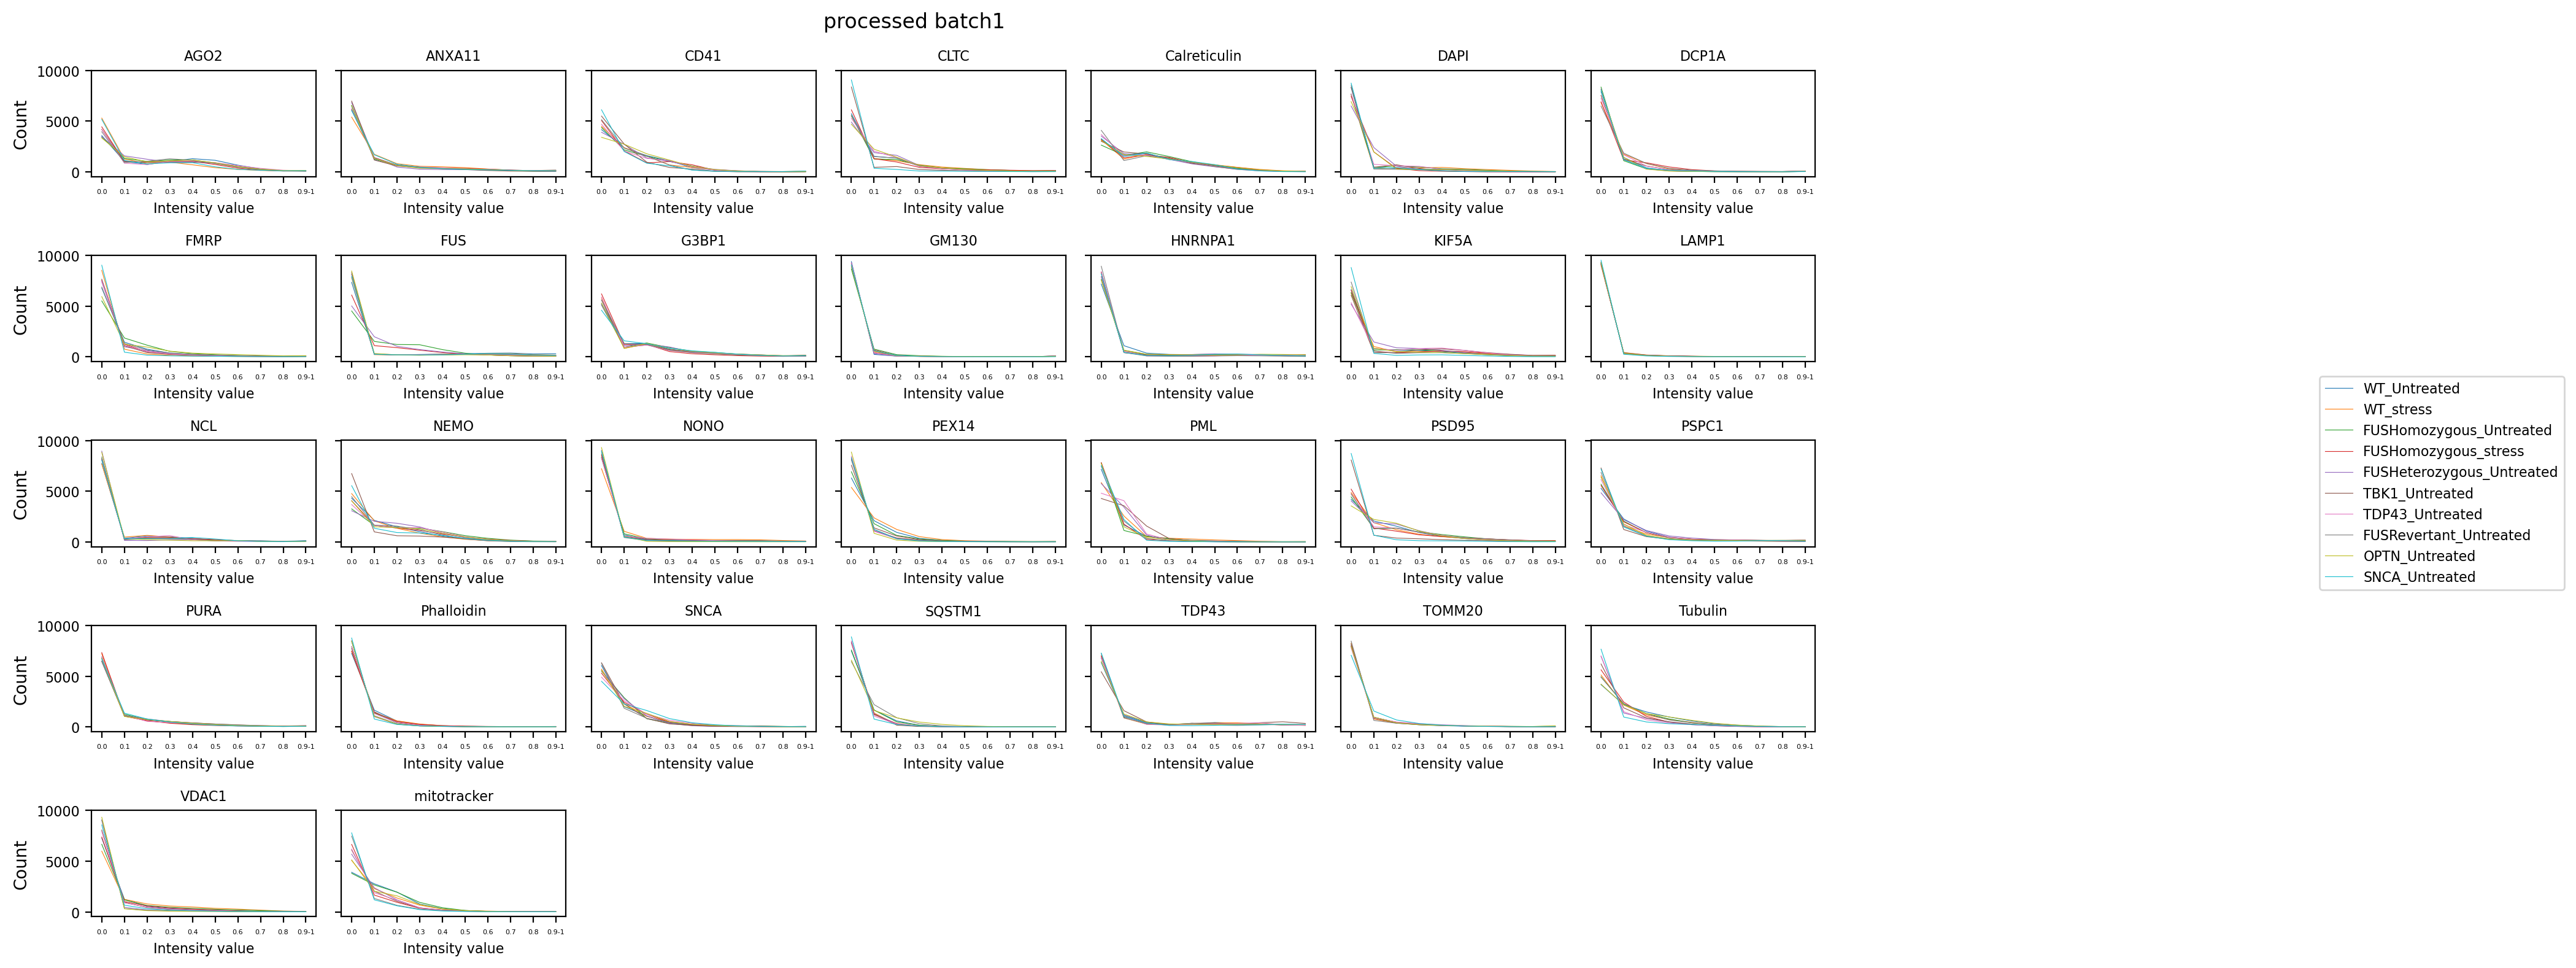

batch2


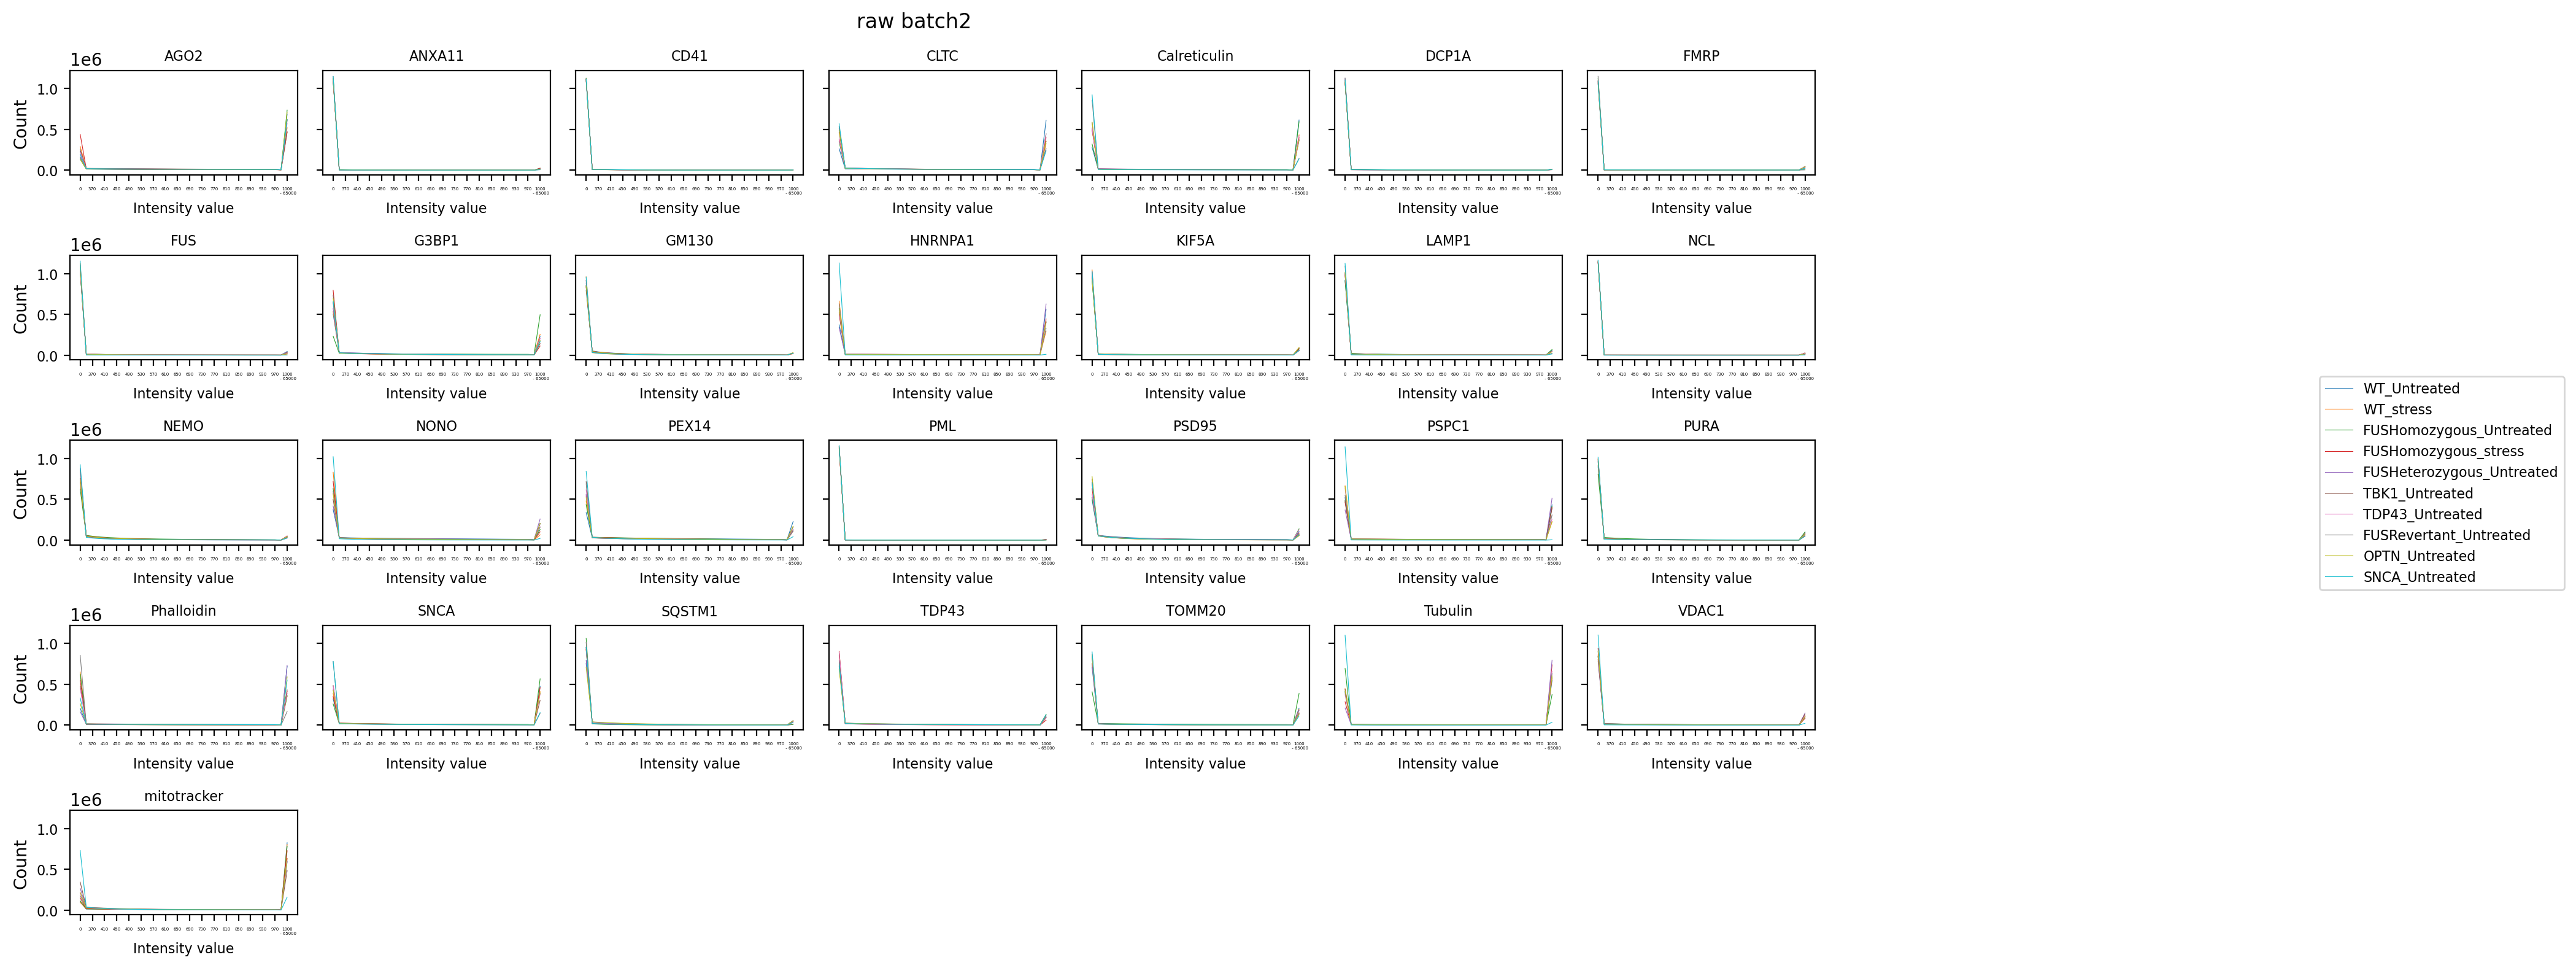

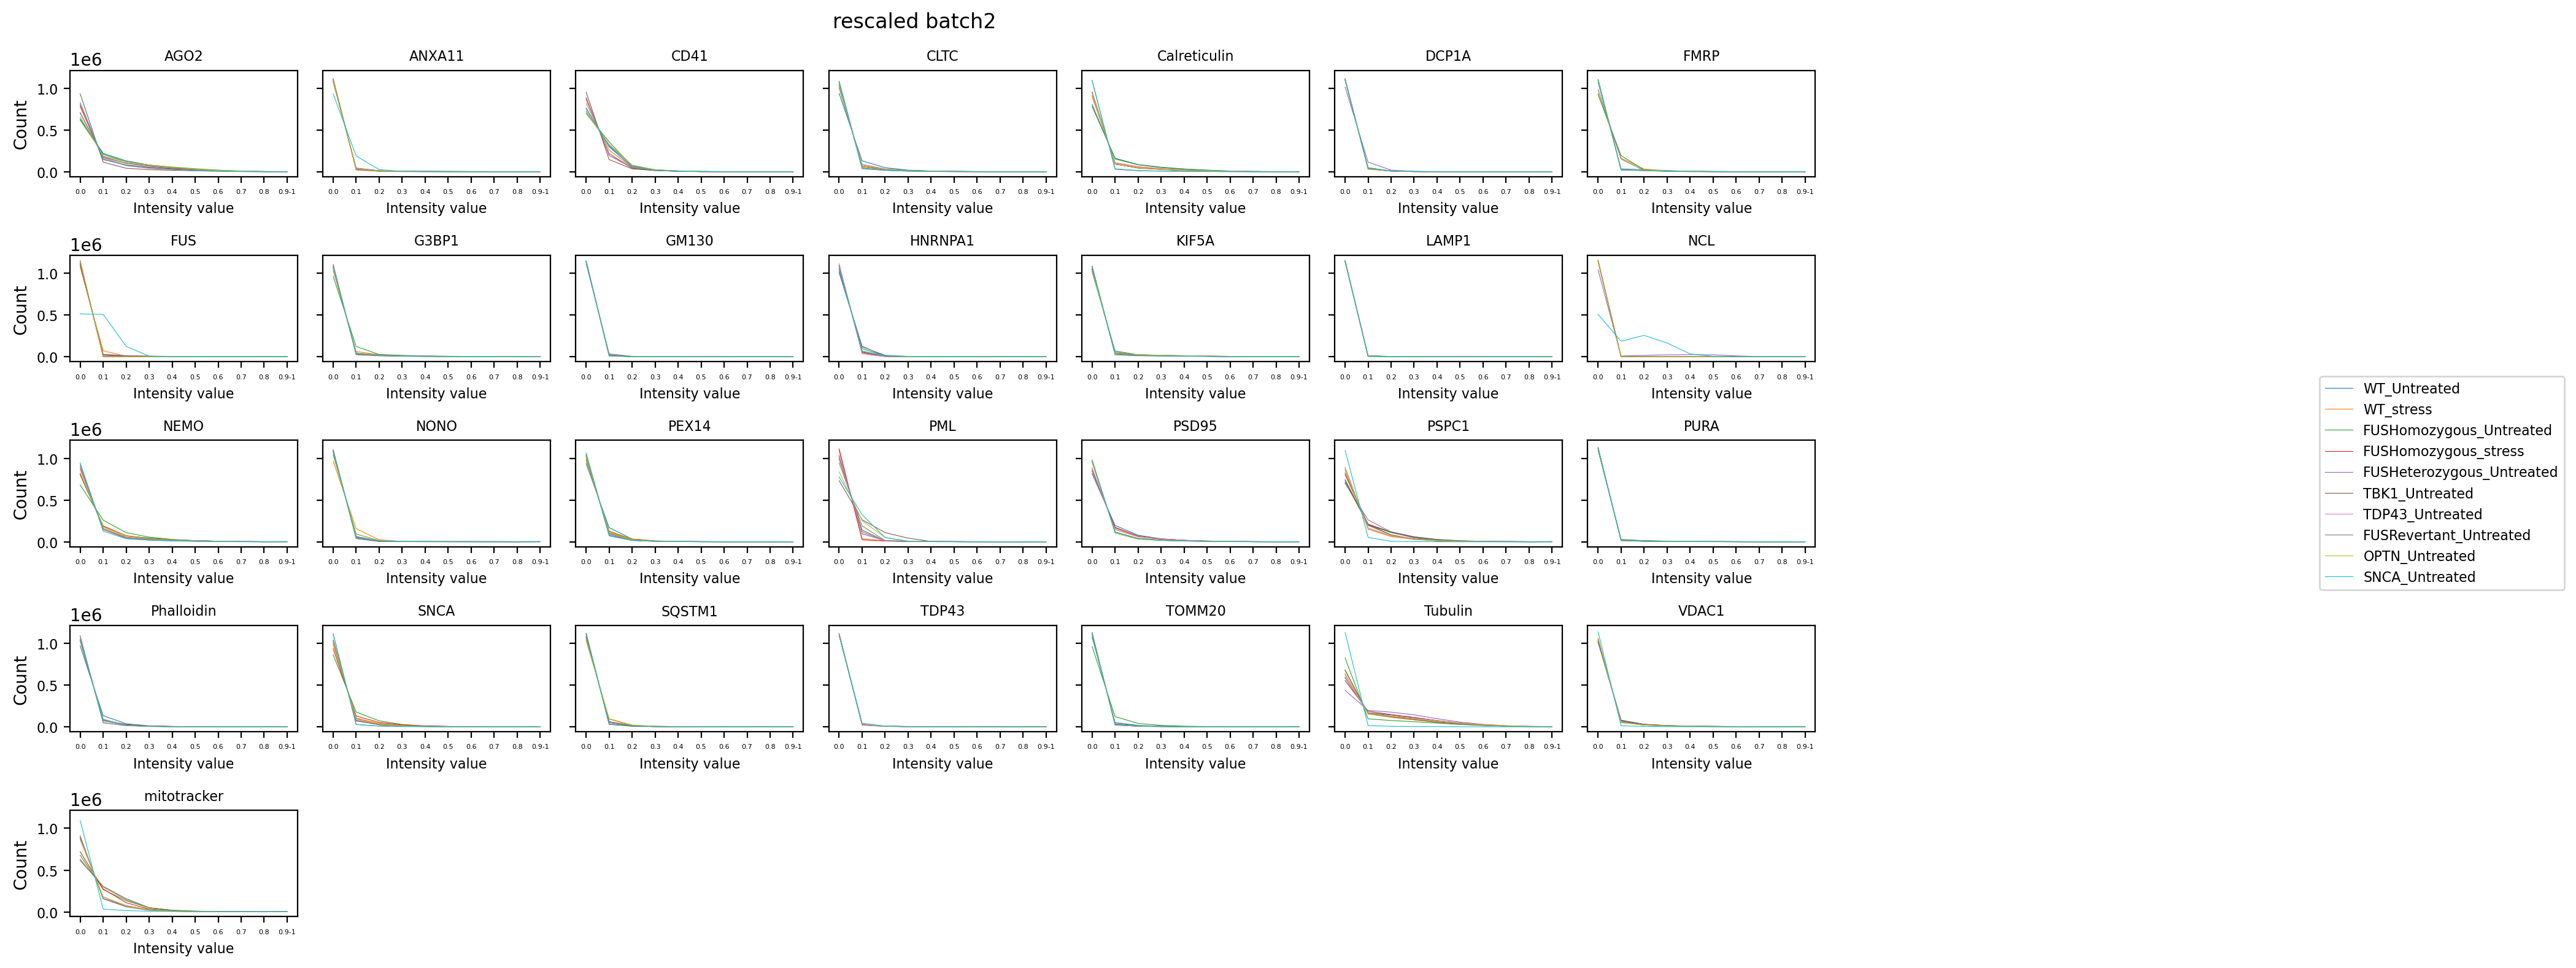

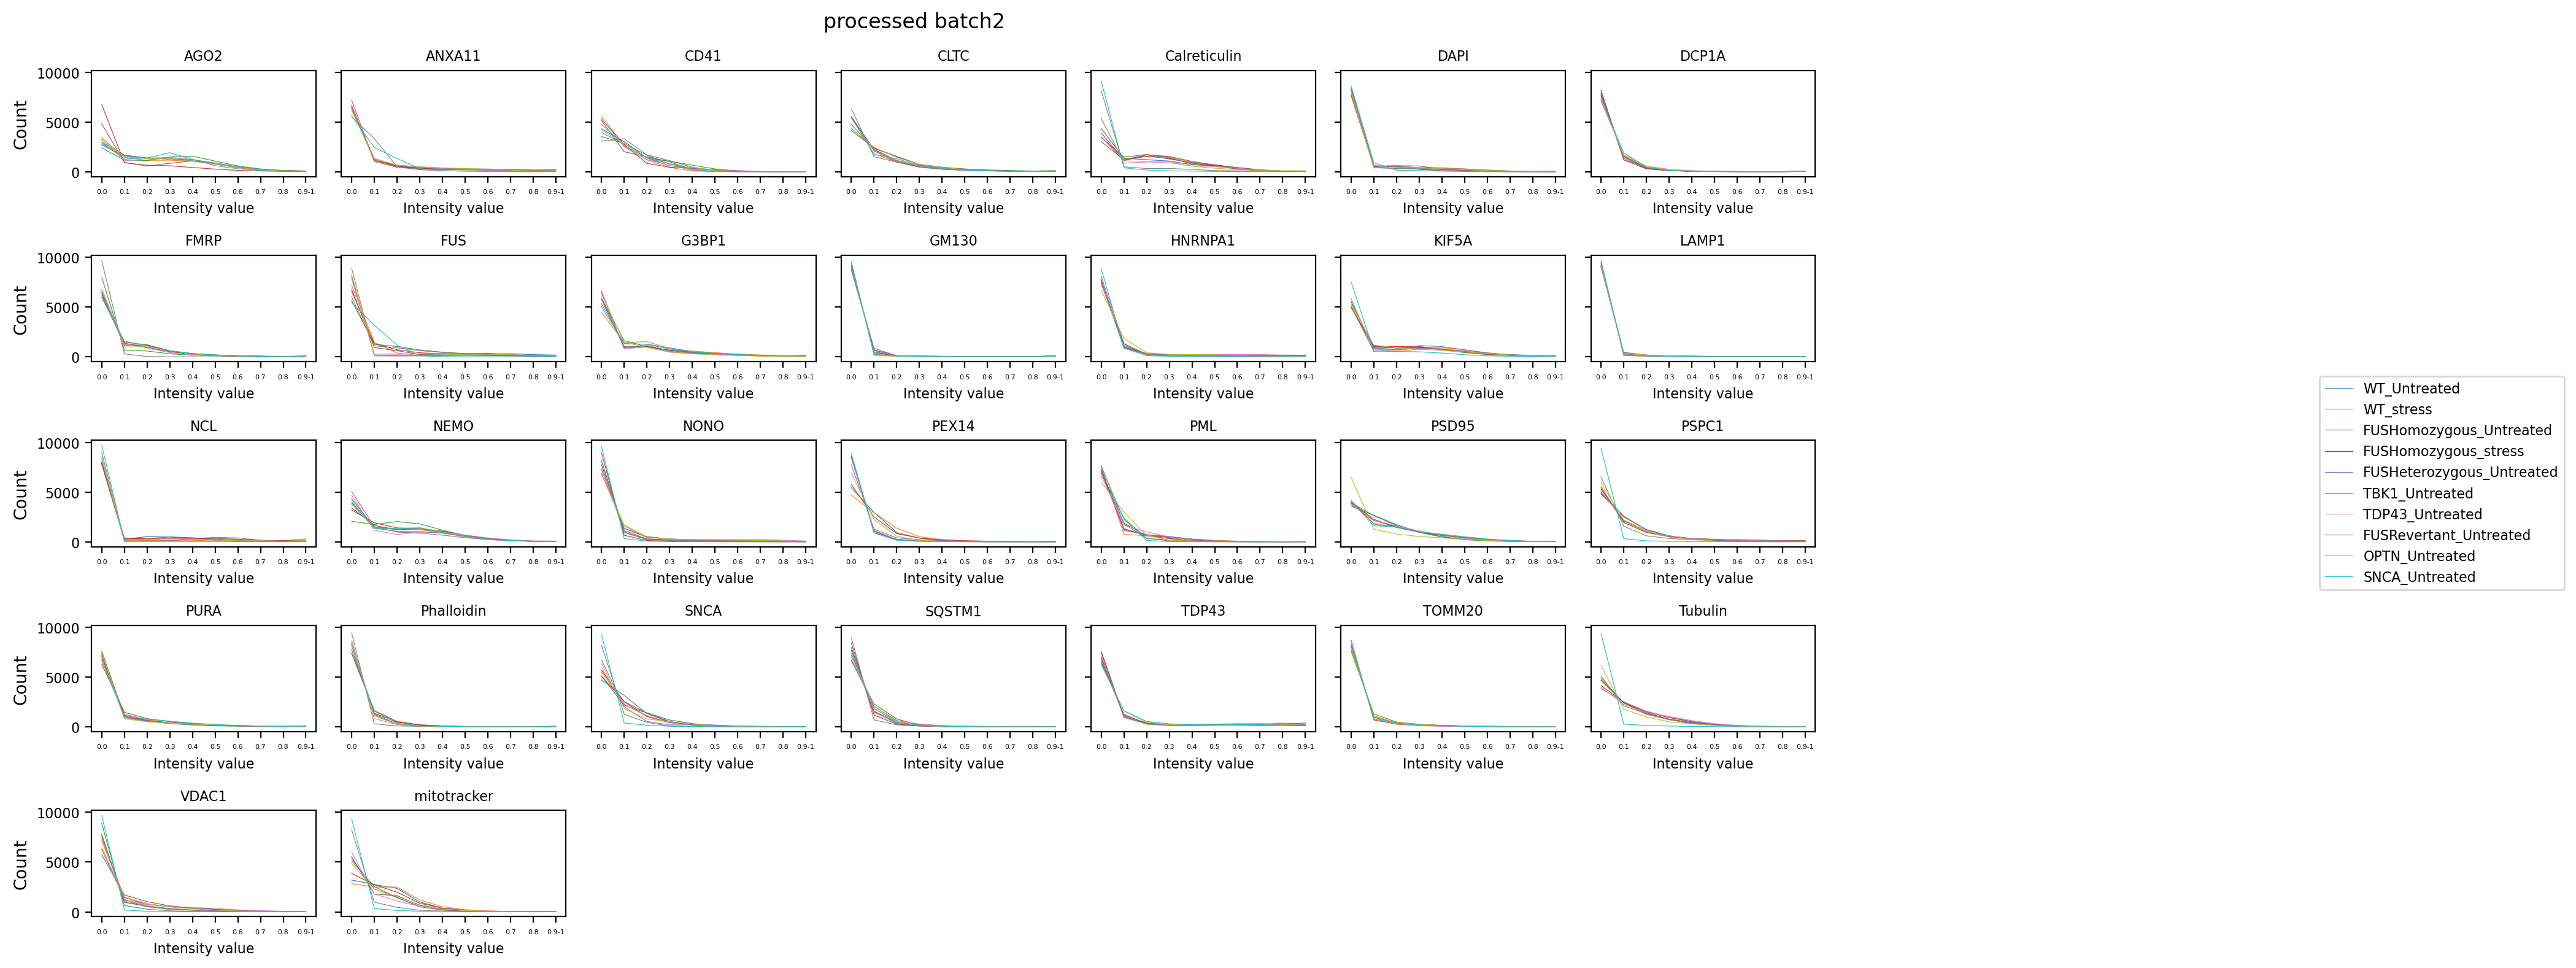

In [9]:
for batch in batches:
    print(batch)
    run_calc_hist_new(f'{batch}',opera18days_cell_lines_for_disp, opera18days_markers, 
                           root_directory_raw, root_directory_proc, hist_sample=10,
                            sample_size_per_markers=200, ncols=7, nrows=5)
    print("="*30)

In [10]:
# save notebook as HTML ( the HTML will be saved in the same folder the original script is)
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
os.system(f'jupyter nbconvert --to html tools/preprocessing_tools/qc_reports/qc_report_d18_Opera.ipynb --output {NOVA_HOME}/manuscript/preprocessing_qc_reports/qc_report_d18_Opera.html')

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook src/preprocessing/notebooks/qc_report_Opera18DaysReimaged.ipynb to html
[NbConvertApp] Writing 8272962 bytes to src/preprocessing/notebooks/qc_report_Opera18DaysReimaged.html


0